In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents


In [48]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/.env


True

In [49]:
%%time

from llm_toolkit.eval_openai import *
from tqdm.notebook import tqdm

tqdm.pandas()

data_path = os.getenv("DATA_PATH")
results_path = "paper/data/ollama_model_results_v3-Jetson_AGX_Orin.csv"
num_ctx = os.getenv("NUM_CTX")
data_path, results_path, num_ctx

CPU times: user 154 μs, sys: 37 μs, total: 191 μs
Wall time: 185 μs


('dataset/GMRID_v3.csv',
 'paper/data/ollama_model_results_v3-Jetson_AGX_Orin.csv',
 '8192')

In [50]:
import pandas as pd
from llm_toolkit.llm_utils import *
from llm_toolkit.data_utils import *

df = pd.read_csv(results_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 80 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1147 non-null   int64  
 1   Headline                             1147 non-null   object 
 2   Details                              1147 non-null   object 
 3   Severity                             1147 non-null   object 
 4   Region                               1147 non-null   object 
 5   Datetime                             1147 non-null   object 
 6   lat                                  757 non-null    float64
 7   lon                                  757 non-null    float64
 8   maritime_label                       1147 non-null   bool   
 9   found_ports                          1147 non-null   object 
 10  contains_port_info                   1147 non-null   bool   
 11  if_labeled                    

In [51]:
df_test = pd.read_csv("dataset/GMRID_v3-test.csv")
df["gpt-4o_label"] = df_test["gpt-4o_label"]
# df.to_csv(results_path, index=False)

In [52]:
model_orders = {
    k.replace("-coder", "").replace("-Coder", ""): v
    for k, v in model_orders.items()
    if "qwq" not in k.lower()
}
model_orders

{'qwen2.5:0.5b': 0.5,
 'qwen2.5:0.5b-instruct-fp16': 0.6,
 'llama3.2:1b': 1,
 'llama3.2:1b-instruct-fp16': 1.05,
 'meta-llama/Llama-3.2-1B-Instruct': 1.1,
 'qwen2.5:1.5b': 1.5,
 'qwen2.5:1.5b-instruct-fp16': 1.506,
 'Qwen/Qwen2.5-1.5B-Instruct': 1.51,
 'llama3.2:3b': 3,
 'llama3.2:3b-instruct-fp16': 3.05,
 'meta-llama/Llama-3.2-3B-Instruct': 3.1,
 'qwen2.5:3b': 4,
 'qwen2.5:3b-instruct-fp16': 4.06,
 'Qwen/Qwen2.5-3B-Instruct': 4.1,
 'microsoft/Phi-3.5-mini-instruct': 5,
 'mistralai/Mistral-7B-Instruct-v0.3': 10,
 'qwen2.5:7b': 12,
 'qwen2.5:7b-instruct-fp16': 12.05,
 'Qwen/Qwen2.5-7B-Instruct': 12.1,
 'llama3.1:8b': 15,
 'llama3.1:8b-instruct-fp16': 15.1,
 'meta-llama/Llama-3.1-8B_4bit': 16,
 'meta-llama/Llama-3.1-8B_4bit_H100': 17,
 'meta-llama/Meta-Llama-3.1-8B-Instruct': 20,
 'llama3.2-vision': 21,
 'llama3.2-vision:11b': 21,
 'llama3.2-vision:11b-instruct-fp16': 21.1,
 'meta-llama/Llama-3.2-11B-Vision-Instruct': 21.5,
 'qwen2.5:14b': 22,
 'qwen2.5:14b-instruct-fp16': 22.05,
 'Qwen/

In [53]:
result_columns = [
    col for col in df.columns.to_list() if col.split("/shots")[0] in model_orders.keys()
]
result_columns.sort()
result_columns = sorted(
    result_columns, key=lambda x: model_orders[x.split("/shots")[0]]
)
result_columns

['qwen2.5:0.5b/shots-00(1.115)',
 'qwen2.5:0.5b/shots-01(1.128)',
 'qwen2.5:0.5b/shots-02(1.139)',
 'qwen2.5:0.5b/shots-04(1.146)',
 'qwen2.5:0.5b/shots-08(1.174)',
 'qwen2.5:0.5b/shots-10(1.192)',
 'llama3.2:1b/shots-00(3.074)',
 'llama3.2:1b/shots-01(3.367)',
 'llama3.2:1b/shots-02(3.522)',
 'llama3.2:1b/shots-04(3.536)',
 'llama3.2:1b/shots-08(3.468)',
 'llama3.2:1b/shots-10(3.599)',
 'qwen2.5:1.5b/shots-00(1.517)',
 'qwen2.5:1.5b/shots-01(1.583)',
 'qwen2.5:1.5b/shots-02(1.589)',
 'qwen2.5:1.5b/shots-04(1.568)',
 'qwen2.5:1.5b/shots-08(1.612)',
 'qwen2.5:1.5b/shots-10(1.635)',
 'llama3.2:3b/shots-00(3.159)',
 'llama3.2:3b/shots-01(2.988)',
 'llama3.2:3b/shots-02(2.976)',
 'llama3.2:3b/shots-04(2.956)',
 'llama3.2:3b/shots-08(3.091)',
 'llama3.2:3b/shots-10(2.999)',
 'qwen2.5:3b/shots-00(2.603)',
 'qwen2.5:3b/shots-01(2.448)',
 'qwen2.5:3b/shots-02(2.475)',
 'qwen2.5:3b/shots-04(2.475)',
 'qwen2.5:3b/shots-08(2.536)',
 'qwen2.5:3b/shots-10(2.586)',
 'qwen2.5:7b/shots-00(4.829)',
 'q

In [54]:
# data_col_start_idx = 12
# result_col_start_idx = 19

# df_test = pd.read_csv("dataset/GMRID_v3-test.csv")
# df["gpt-4o_label"] = df_test["gpt-4o_label"]
# df_results = df[
#     df.columns.to_list()[data_col_start_idx:result_col_start_idx] + ["gpt-4o_label"] + result_columns
# ]

# df_results.info()

In [55]:
# df_results.to_csv(results_path, index=False)

In [56]:
data_col_start_idx = 12
result_col_start_idx = 20

In [57]:
df_results = df[
    df.columns.to_list()[data_col_start_idx:result_col_start_idx] + result_columns
]
df = df_results

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 68 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Headline_Details                     1146 non-null   object
 1   Year                                 1147 non-null   int64 
 2   Month                                1147 non-null   int64 
 3   Week                                 1147 non-null   int64 
 4   Details_cleaned                      1147 non-null   object
 5   Category                             1147 non-null   object
 6   Summarized_label                     1147 non-null   object
 7   gpt-4o_label                         1147 non-null   object
 8   qwen2.5:0.5b/shots-00(1.115)         1147 non-null   object
 9   qwen2.5:0.5b/shots-01(1.128)         1147 non-null   object
 10  qwen2.5:0.5b/shots-02(1.139)         1147 non-null   object
 11  qwen2.5:0.5b/shots-04(1.146)         1147 n

In [59]:
metrics_df = get_metrics(
    df,
    result_col_start_idx - data_col_start_idx,
    mean_eval_time=True,
    label_column="gpt-4o_label",
    # debug=True,
)
metrics_df

qwen2.5:0.5b/shots-00(1.115) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-00(1.115) - metrics: {'f1': 0.39673984784748356, 'accuracy': 0.3269398430688753}
Generating prompt templates for 0 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-01(1.128) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-01(1.128) - metrics: {'f1': 0.45653833141522, 'accuracy': 0.41935483870967744}
Generating prompt templates for 1 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-02(1.139) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-02(1.139) - metrics: {'f1': 0.4454301259236429, 'accuracy': 0.44289450741063646}
Generating prompt templates for 2 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-04(1.146) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-04(1.146) - metrics: {'f1': 0.410392950210585, 'accuracy': 0.44725370531822145}
Generating prompt templates for 4 shots with Headline_Details and gpt-4o_l

model  shots  eval_time        f1  accuracy  f1_raw  \
0          qwen2.5:0.5b      0      1.115  0.396740  0.326940     0.0   
1          qwen2.5:0.5b      1      1.128  0.456538  0.419355     0.0   
2          qwen2.5:0.5b      2      1.139  0.445430  0.442895     0.0   
3          qwen2.5:0.5b      4      1.146  0.410393  0.447254     0.0   
4          qwen2.5:0.5b      8      1.174  0.455115  0.503923     0.0   
5          qwen2.5:0.5b     10      1.192  0.466507  0.497820     0.0   
6           llama3.2:1b      0      3.074  0.634092  0.586748     0.0   
7           llama3.2:1b      1      3.367  0.607910  0.611160     0.0   
8           llama3.2:1b      2      3.522  0.627595  0.607672     0.0   
9           llama3.2:1b      4      3.536  0.592132  0.575414     0.0   
10          llama3.2:1b      8      3.468  0.503509  0.525719     0.0   
11          llama3.2:1b     10      3.599  0.582847  0.602441     0.0   
12         qwen2.5:1.5b      0      1.517  0.592242  0.517001     0.0   
13         qwen2.5:1.5b      1      1.583  0.721632  0.630340     0.0   
14         qwen2.5:1.5b      2      1.589  0.717963  0.620750     0.0   
15         qwen2.5:1.5b      4      1.568  0.678930  0.586748     0.0   
16         qwen2.5:1.5b      8      1.612  0.634429  0.551874     0.0   
17         qwen2.5:1.5b     10      1.635  0.694170  0.613775     0.0   
18          llama3.2:3b      0      3.159  0.677201  0.681779     0.0   
19          llama3.2:3b      1      2.988  0.777526  0.767219     0.0   
20          llama3.2:3b      2      2.976  0.797243  0.782040     0.0   
21          llama3.2:3b      4      2.956  0.803096  0.789887     0.0   
22          llama3.2:3b      8      3.091  0.843377  0.837838     0.0   
23          llama3.2:3b     10      2.999  0.843127  0.836966     0.0   
24           qwen2.5:3b      0      2.603  0.742595  0.734961     0.0   
25           qwen2.5:3b      1      2.448  0.883499  0.862249     0.0   
26           qwen2.5:3b      2      2.475  0.886585  0.860506     0.0   
27           qwen2.5:3b      4      2.475  0.891215  0.865737     0.0   
28           qwen2.5:3b      8      2.536  0.904551  0.884045     0.0   
29           qwen2.5:3b     10      2.586  0.902074  0.882302     0.0   
30           qwen2.5:7b      0      4.829  0.901877  0.899738     0.0   
31           qwen2.5:7b      1      4.585  0.914769  0.900610     0.0   
32           qwen2.5:7b      2      4.830  0.922242  0.916303     0.0   
33           qwen2.5:7b      4      4.911  0.920141  0.913688     0.0   
34           qwen2.5:7b      8      5.072  0.913783  0.904098     0.0   
35           qwen2.5:7b     10      5.130  0.927761  0.921534     0.0   
36          llama3.1:8b      0      5.173  0.739447  0.751526     0.0   
37          llama3.1:8b      1      4.385  0.906257  0.903226     0.0   
38          llama3.1:8b      2      4.548  0.880676  0.879686     0.0   
39          llama3.1:8b      4      4.631  0.921003  0.919791     0.0   
40          llama3.1:8b      8      5.138  0.923233  0.922406     0.0   
41          llama3.1:8b     10      5.146  0.931014  0.931125     0.0   
42  llama3.2-vision:11b      0      5.079  0.731688  0.744551     0.0   
43  llama3.2-vision:11b      1      4.306  0.896918  0.893636     0.0   
44  llama3.2-vision:11b      2      4.465  0.870552  0.870096     0.0   
45  llama3.2-vision:11b      4      4.475  0.911661  0.910201     0.0   
46  llama3.2-vision:11b      8      4.529  0.914268  0.912816     0.0   
47  llama3.2-vision:11b     10      4.585  0.928220  0.927637     0.0   
48          qwen2.5:14b      0      9.113  0.885321  0.884045     0.0   
49          qwen2.5:14b      1      8.777  0.945729  0.941587     0.0   
50          qwen2.5:14b      2      8.914  0.944186  0.941587     0.0   
51          qwen2.5:14b      4      9.422  0.930297  0.925894     0.0   
52          qwen2.5:14b      8      9.922  0.938399  0.935484     0.0   
53          qwen2.5:14b     10     10.304  0.950598  0.947690     0.0   
54 

In [60]:
models = metrics_df["model"].unique()
models

array(['qwen2.5:0.5b', 'llama3.2:1b', 'qwen2.5:1.5b', 'llama3.2:3b',
       'qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b', 'llama3.2-vision:11b',
       'qwen2.5:14b', 'qwen2.5:32b'], dtype=object)

In [61]:
all_models = models.tolist()
llama_models = [x for x in all_models if "llama" in x.lower()]
qwen_models = [x for x in all_models if "qw" in x.lower()]
llama_models, qwen_models

(['llama3.2:1b', 'llama3.2:3b', 'llama3.1:8b', 'llama3.2-vision:11b'],
 ['qwen2.5:0.5b',
  'qwen2.5:1.5b',
  'qwen2.5:3b',
  'qwen2.5:7b',
  'qwen2.5:14b',
  'qwen2.5:32b'])

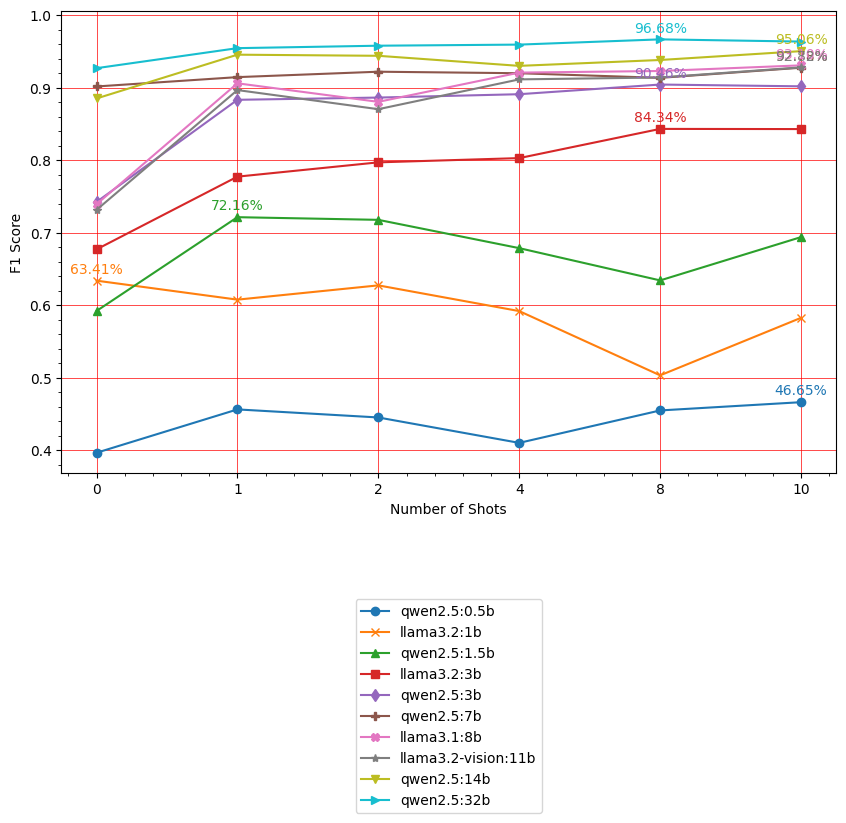

In [62]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.75),
)

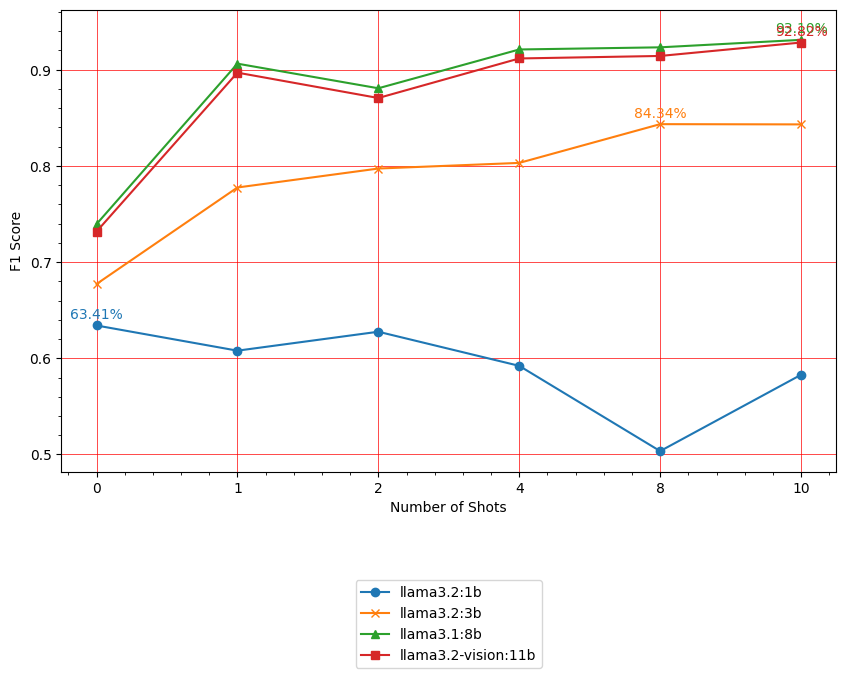

In [63]:
plot_metrics_vs_shots(
    metrics_df,
    llama_models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.44),
)

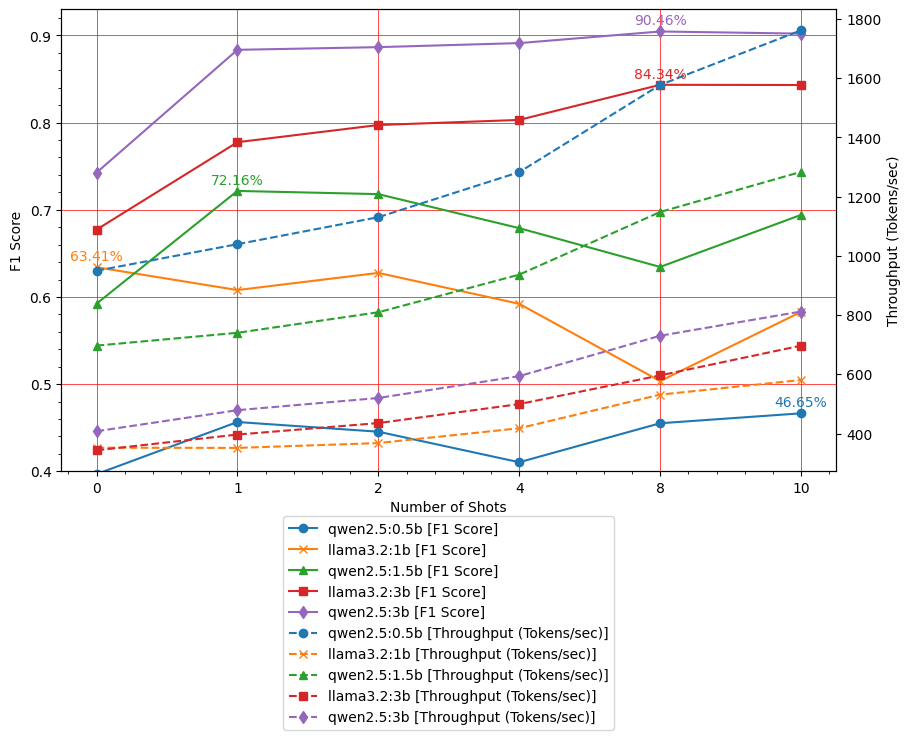

In [64]:
plot_metrics_vs_shots(
    metrics_df,
    models[:5],
    markers[:5],
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    ylimits=(0.4, 0.92),
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.575),
)

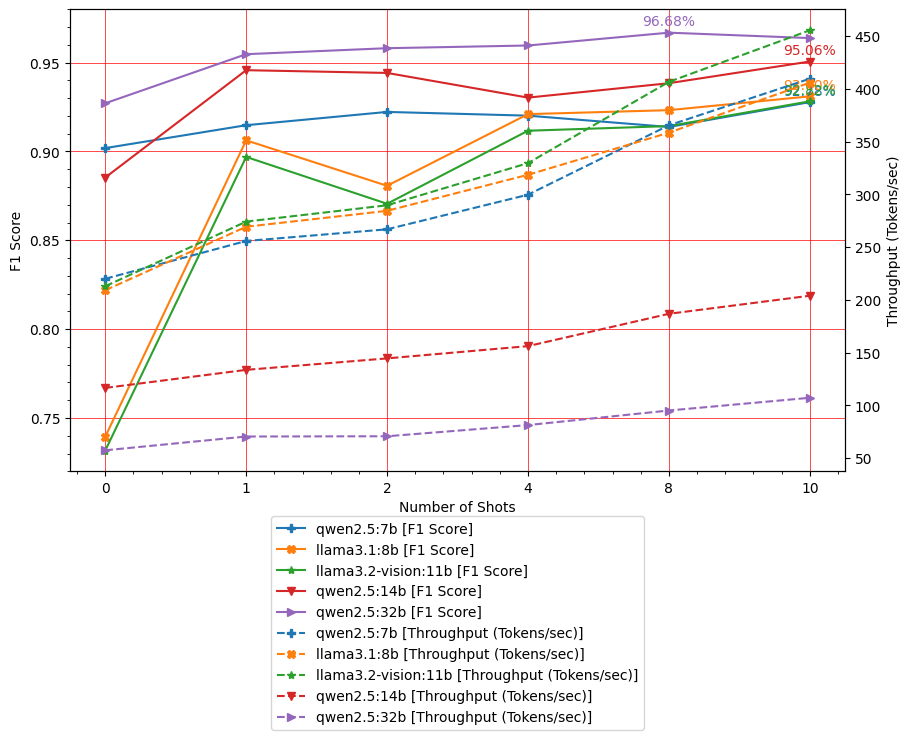

In [65]:
plot_metrics_vs_shots(
    metrics_df,
    models[5:10],
    markers[5:10],
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    ylimits=(0.72, 0.97),
    # log_scales=[False, True],
    bbox_to_anchor=(0.5, -0.575),
)

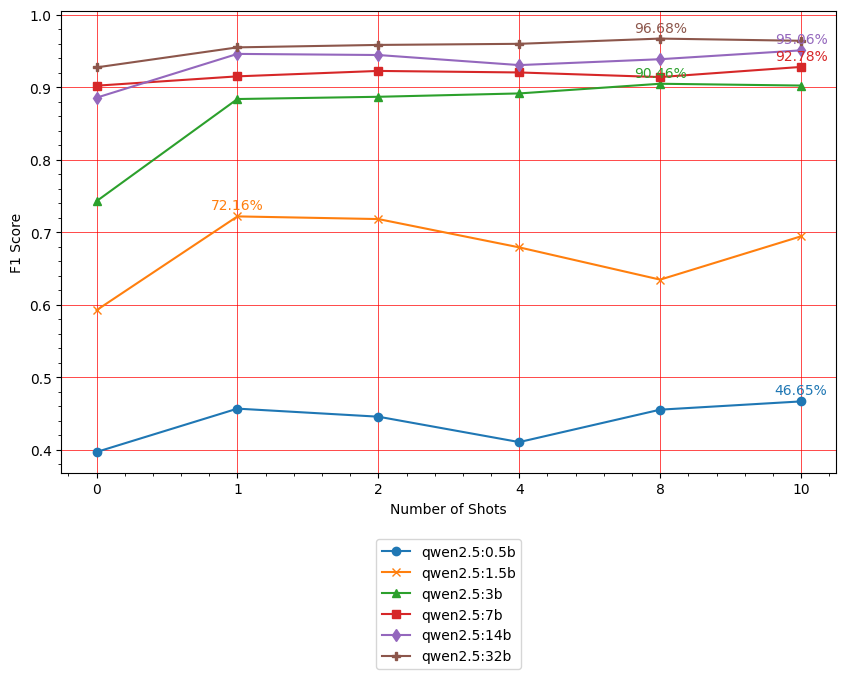

In [66]:
plot_metrics_vs_shots(
    metrics_df,
    qwen_models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.44),
)

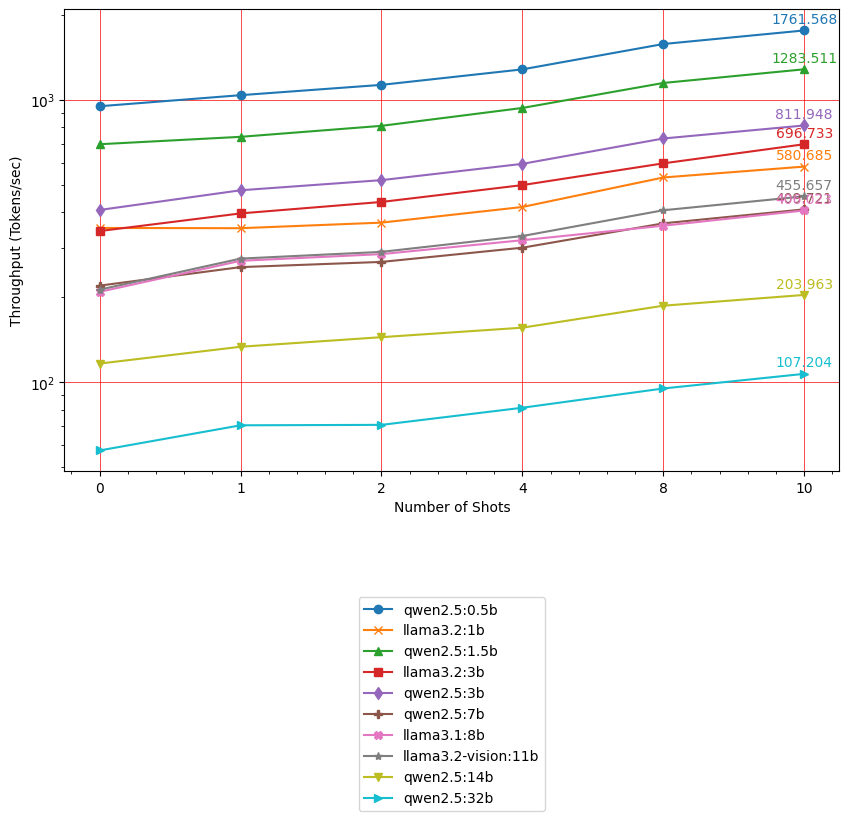

In [67]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    use_percentage=False,
)

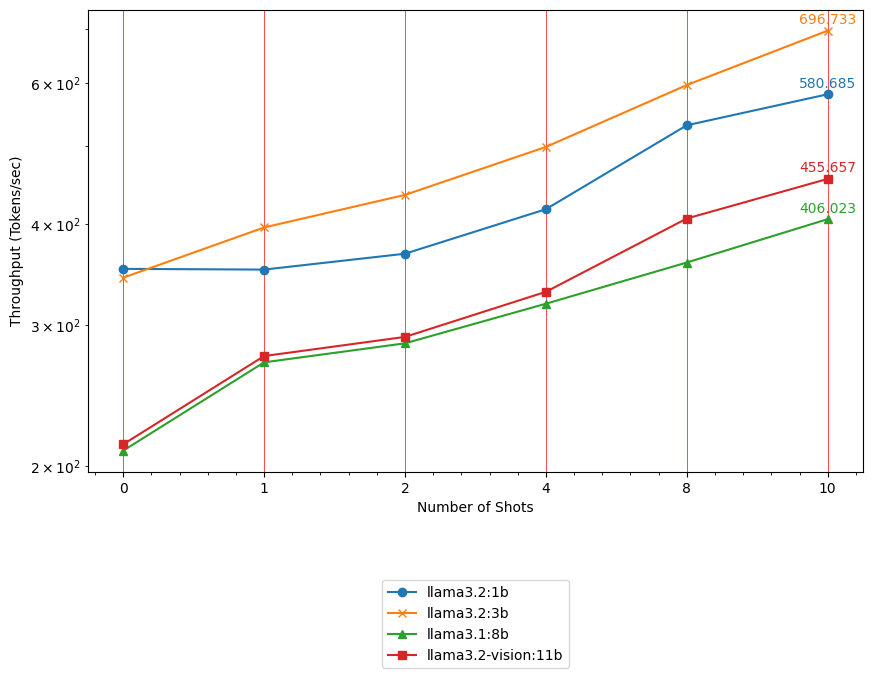

In [68]:
plot_metrics_vs_shots(
    metrics_df,
    llama_models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.44),
    use_percentage=False,
)

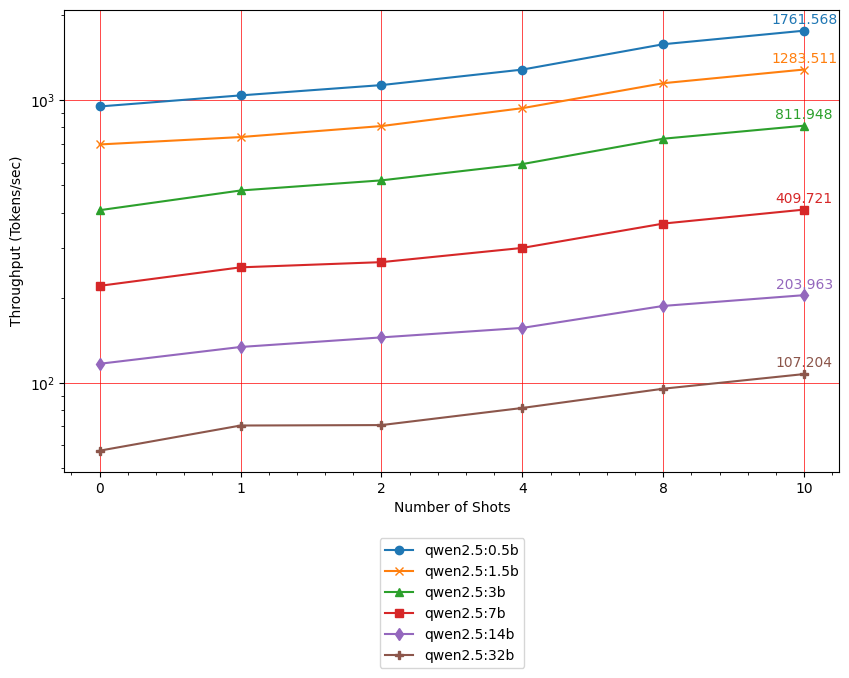

In [69]:
plot_metrics_vs_shots(
    metrics_df,
    qwen_models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.44),
    use_percentage=False,
)

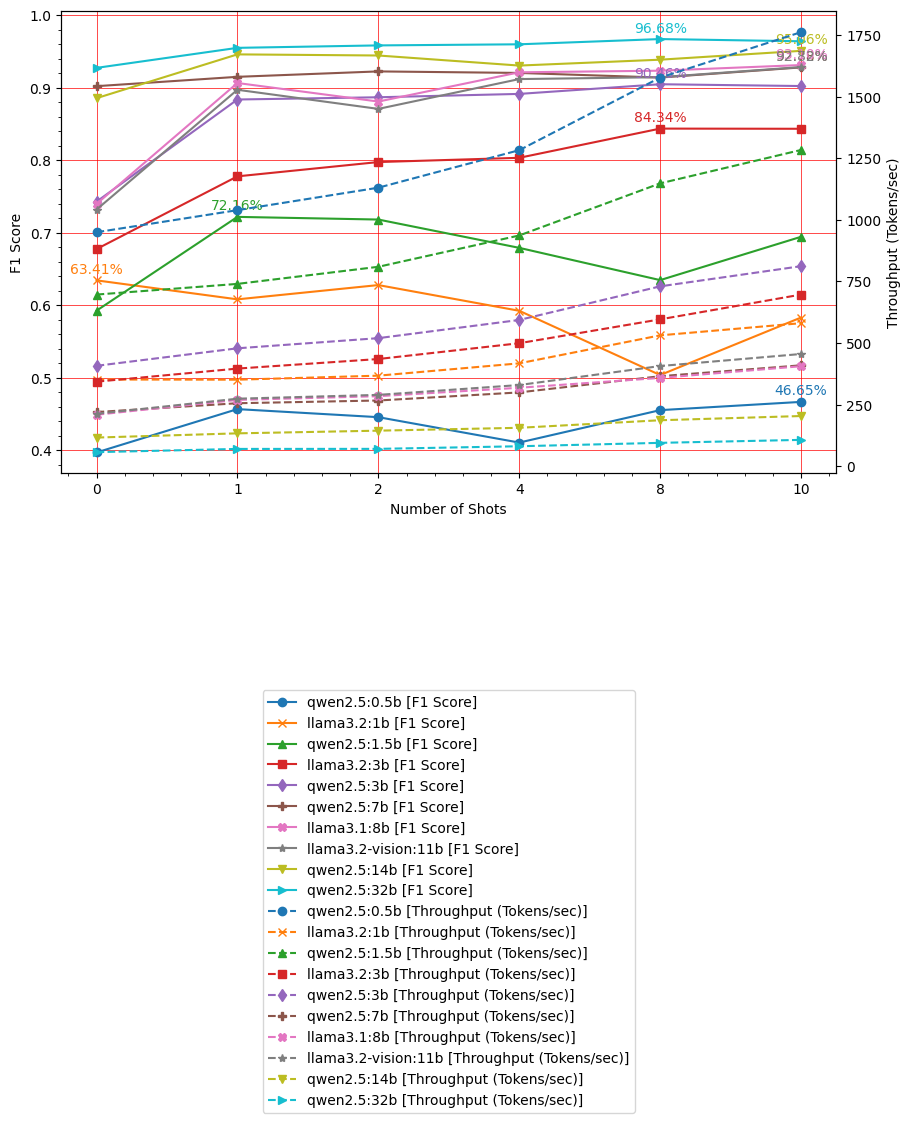

In [70]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    bbox_to_anchor=(0.5, -1.4),
)

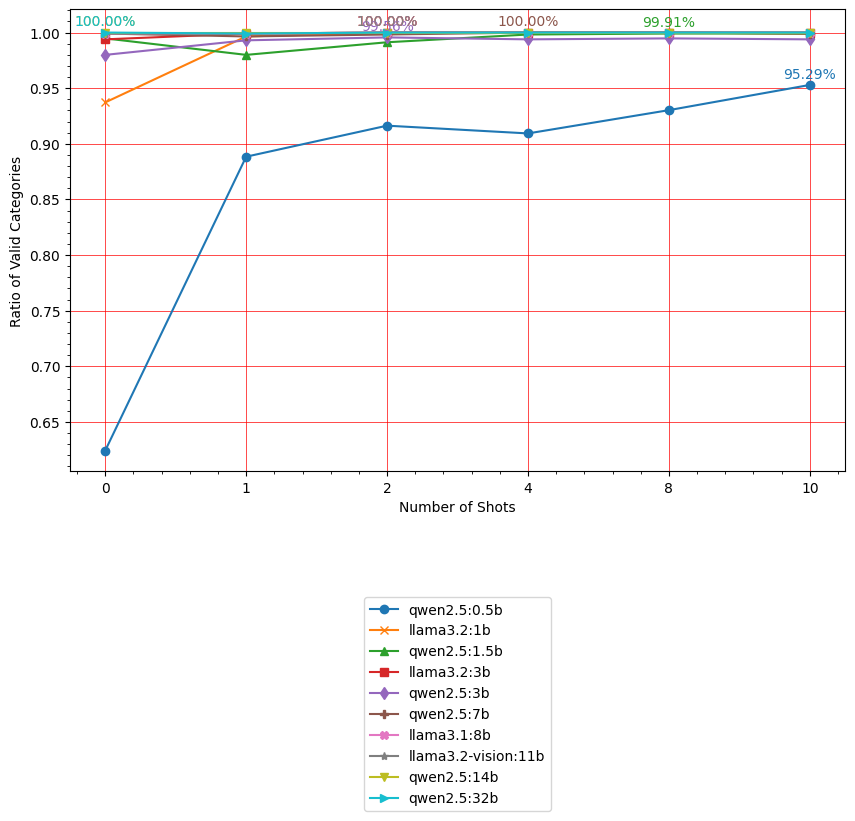

In [71]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["ratio_valid_categories"],
    ["Ratio of Valid Categories"],
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    ylimits_offset=0.002,
)

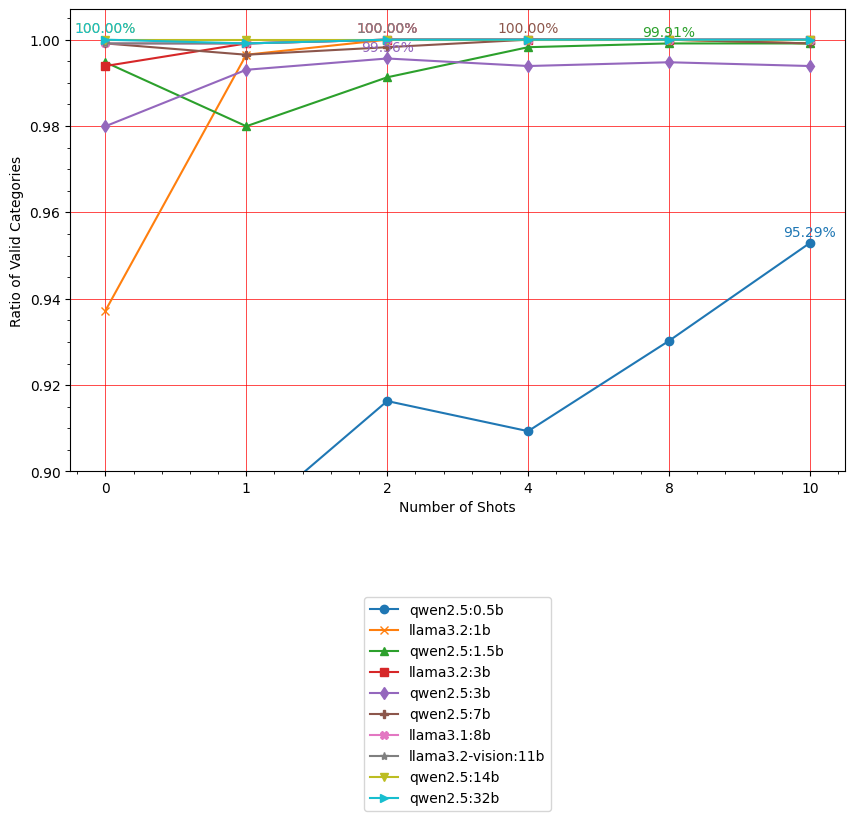

In [72]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["ratio_valid_categories"],
    ["Ratio of Valid Categories"],
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    ylimits=[0.9, 1.005],
    ylimits_offset=0.002,
)

In [73]:
top_metrics_df = get_top_metrics_df(metrics_df)
top_metrics_df

model  shots  eval_time        f1  accuracy  f1_raw  \
5          qwen2.5:0.5b     10      1.192  0.466507  0.497820     0.0   
6           llama3.2:1b      0      3.074  0.634092  0.586748     0.0   
13         qwen2.5:1.5b      1      1.583  0.721632  0.630340     0.0   
22          llama3.2:3b      8      3.091  0.843377  0.837838     0.0   
28           qwen2.5:3b      8      2.536  0.904551  0.884045     0.0   
35           qwen2.5:7b     10      5.130  0.927761  0.921534     0.0   
41          llama3.1:8b     10      5.146  0.931014  0.931125     0.0   
47  llama3.2-vision:11b     10      4.585  0.928220  0.927637     0.0   
53          qwen2.5:14b     10     10.304  0.950598  0.947690     0.0   
58          qwen2.5:32b      8     19.497  0.966846  0.965998     0.0   

    accuracy_raw  ratio_valid_categories  total_tokens   eval_speed  
5            0.0                0.952921       2408458  1761.567965  
6            0.0                0.937228       1241517   352.115700  
13           0.0                0.979948       1343758   740.076698  
22           0.0                1.000000       2113789   596.209938  
28           0.0                0.994769       2123708   730.099643  
35           0.0                0.999128       2410843   409.720926  
41           0.0                1.000000       2396535   406.022944  
47           0.0                1.000000       2396298   455.657022  
53           0.0                1.000000       2410577   203.963164  
58           0.0                1.000000       2127660    95.141725

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


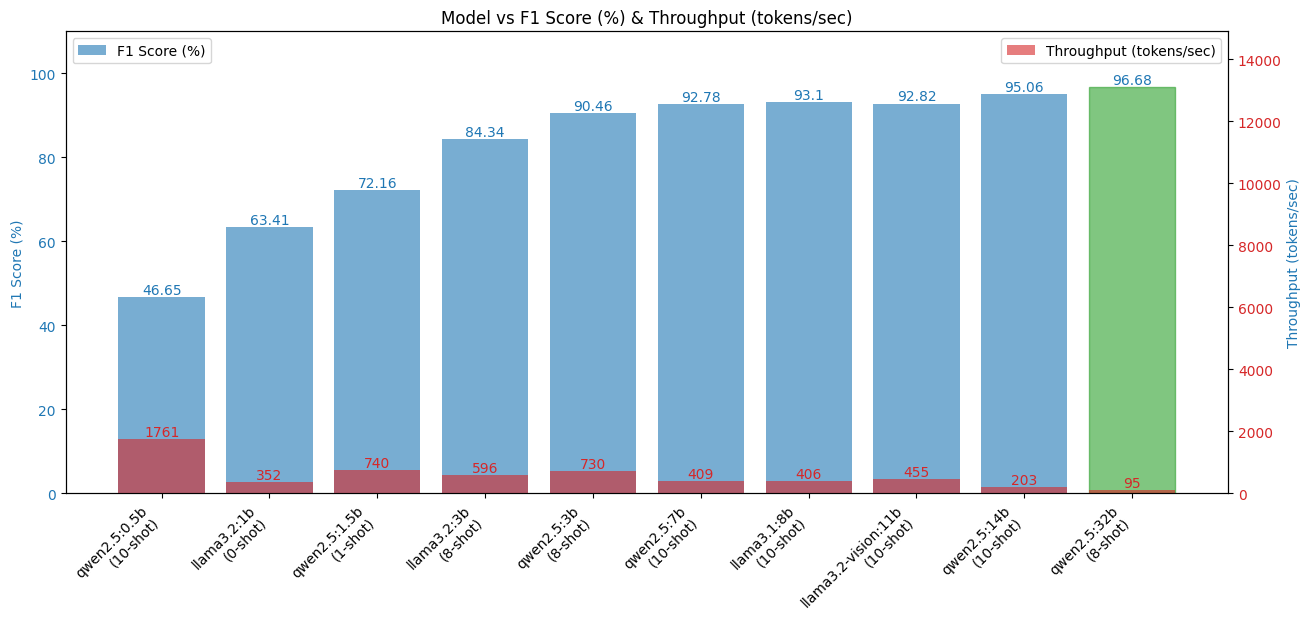

In [74]:
plot_metrics_bar_charts(top_metrics_df, second_ylim=[0, 14900])

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


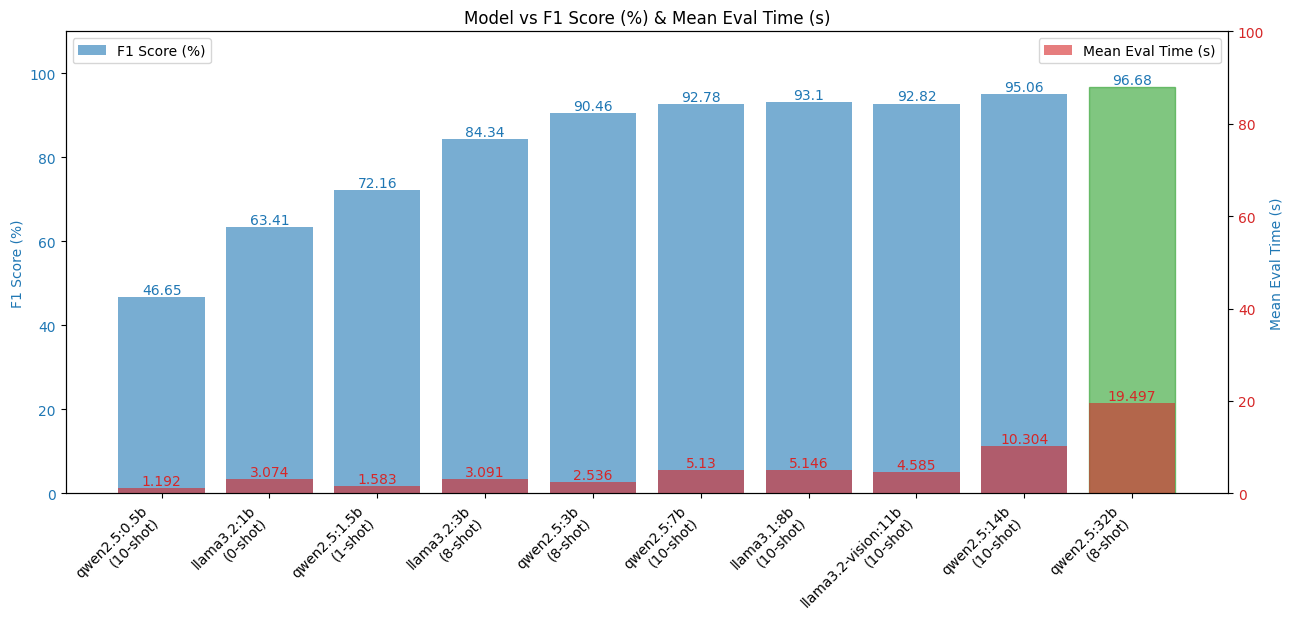

In [75]:
plot_metrics_bar_charts(
    top_metrics_df,
    second_column="eval_time",
    second_title="Mean Eval Time (s)",
    second_ylim=(0, 100),
    second_decimals=3,
)

In [76]:
ensemble_models = [
    m
    for m in all_models
    if "fp" not in m
    and top_metrics_df[top_metrics_df["model"] == m].iloc[0]["f1"] >= 0.9
]
ensemble_models

['qwen2.5:3b',
 'qwen2.5:7b',
 'llama3.1:8b',
 'llama3.2-vision:11b',
 'qwen2.5:14b',
 'qwen2.5:32b']

In [77]:
ensemble_models = ensemble_models[:5]
ensemble_models

['qwen2.5:3b',
 'qwen2.5:7b',
 'llama3.1:8b',
 'llama3.2-vision:11b',
 'qwen2.5:14b']

In [78]:
def majority_vote(v1, v2, v3):
    v1_ans, v2_ans, v3_ans = extract_answer(v1), extract_answer(v2), extract_answer(v3)
    if v2_ans == v3_ans and v3_ans != v1_ans:
        return v2

    return v1

In [79]:
import itertools

permutations = list(itertools.combinations(ensemble_models, 3))

for perm in permutations:
    print(perm)

('qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b')
('qwen2.5:3b', 'qwen2.5:7b', 'llama3.2-vision:11b')
('qwen2.5:3b', 'qwen2.5:7b', 'qwen2.5:14b')
('qwen2.5:3b', 'llama3.1:8b', 'llama3.2-vision:11b')
('qwen2.5:3b', 'llama3.1:8b', 'qwen2.5:14b')
('qwen2.5:3b', 'llama3.2-vision:11b', 'qwen2.5:14b')
('qwen2.5:7b', 'llama3.1:8b', 'llama3.2-vision:11b')
('qwen2.5:7b', 'llama3.1:8b', 'qwen2.5:14b')
('qwen2.5:7b', 'llama3.2-vision:11b', 'qwen2.5:14b')
('llama3.1:8b', 'llama3.2-vision:11b', 'qwen2.5:14b')


In [80]:
for perm in permutations:
    print(perm)
    selected_rows = top_metrics_df[top_metrics_df["model"].isin(perm)]
    selected_rows = selected_rows.sort_values(by="f1", ascending=False)

    columns = []
    shots = 0
    eval_time = 0
    title = None
    for idx, row in selected_rows.iterrows():
        columns.append(
            f"{row['model']}/shots-{row['shots']:02d}({row['eval_time']:.3f})"
        )
        shots += row["shots"]
        eval_time += row["eval_time"]
        if title:
            title += f"_{row['model']}"
        else:
            title = row["model"]

    print(title, eval_time, columns)

    df_results[f"{title}/shots-{shots}({eval_time:.3f})"] = df_results.apply(
        lambda x: majority_vote(x[columns[0]], x[columns[1]], x[columns[2]]), axis=1
    )

('qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b')
llama3.1:8b_qwen2.5:7b_qwen2.5:3b 12.812 ['llama3.1:8b/shots-10(5.146)', 'qwen2.5:7b/shots-10(5.130)', 'qwen2.5:3b/shots-08(2.536)']
('qwen2.5:3b', 'qwen2.5:7b', 'llama3.2-vision:11b')
llama3.2-vision:11b_qwen2.5:7b_qwen2.5:3b 12.251 ['llama3.2-vision:11b/shots-10(4.585)', 'qwen2.5:7b/shots-10(5.130)', 'qwen2.5:3b/shots-08(2.536)']
('qwen2.5:3b', 'qwen2.5:7b', 'qwen2.5:14b')
qwen2.5:14b_qwen2.5:7b_qwen2.5:3b 17.970000000000002 ['qwen2.5:14b/shots-10(10.304)', 'qwen2.5:7b/shots-10(5.130)', 'qwen2.5:3b/shots-08(2.536)']
('qwen2.5:3b', 'llama3.1:8b', 'llama3.2-vision:11b')
llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b 12.267 ['llama3.1:8b/shots-10(5.146)', 'llama3.2-vision:11b/shots-10(4.585)', 'qwen2.5:3b/shots-08(2.536)']
('qwen2.5:3b', 'llama3.1:8b', 'qwen2.5:14b')
qwen2.5:14b_llama3.1:8b_qwen2.5:3b 17.986 ['qwen2.5:14b/shots-10(10.304)', 'llama3.1:8b/shots-10(5.146)', 'qwen2.5:3b/shots-08(2.536)']
('qwen2.5:3b', 'llama3.2-vision:11b', 'qwen2.5:

In [81]:
ensemble_metrics_df = get_metrics(
    df_results, -len(permutations), mean_eval_time=True, label_column="gpt-4o_label"
)
ensemble_metrics_df

llama3.1:8b_qwen2.5:7b_qwen2.5:3b/shots-28(12.812) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
llama3.1:8b_qwen2.5:7b_qwen2.5:3b/shots-28(12.812) - metrics: {'f1': 0.938536106700986, 'accuracy': 0.934612031386225}
Generating prompt templates for 28 shots with Headline_Details and gpt-4o_label
llama3.2-vision:11b_qwen2.5:7b_qwen2.5:3b/shots-28(12.251) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
llama3.2-vision:11b_qwen2.5:7b_qwen2.5:3b/shots-28(12.251) - metrics: {'f1': 0.9383142275653283, 'accuracy': 0.9337401918047079}
Generating prompt templates for 28 shots with Headline_Details and gpt-4o_label
qwen2.5:14b_qwen2.5:7b_qwen2.5:3b/shots-28(17.970) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:14b_qwen2.5:7b_qwen2.5:3b/shots-28(17.970) - metrics: {'f1': 0.9426020040682381, 'accuracy': 0.9380993897122929}
Generating prompt templates for 28 shots with Headline_Details and gpt-4o_label
llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b/shots-28(12.267) - metrics_raw: {'f1': 0.0, 'accuracy':

model  shots  eval_time        f1  \
0            llama3.1:8b_qwen2.5:7b_qwen2.5:3b     28     12.812  0.938536   
1    llama3.2-vision:11b_qwen2.5:7b_qwen2.5:3b     28     12.251  0.938314   
2            qwen2.5:14b_qwen2.5:7b_qwen2.5:3b     28     17.970  0.942602   
3   llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b     28     12.267  0.934050   
4           qwen2.5:14b_llama3.1:8b_qwen2.5:3b     28     17.986  0.949355   
5   qwen2.5:14b_llama3.2-vision:11b_qwen2.5:3b     28     17.425  0.947609   
6   llama3.1:8b_llama3.2-vision:11b_qwen2.5:7b     30     14.861  0.933080   
7           qwen2.5:14b_llama3.1:8b_qwen2.5:7b     30     20.580  0.949903   
8   qwen2.5:14b_llama3.2-vision:11b_qwen2.5:7b     30     20.019  0.951267   
9  qwen2.5:14b_llama3.1:8b_llama3.2-vision:11b     30     20.035  0.936159   

   accuracy  f1_raw  accuracy_raw  ratio_valid_categories  total_tokens  \
0  0.934612     0.0           0.0                     1.0       2505141   
1  0.933740     0.0           0.0                     1.0       2504864   
2  0.938099     0.0           0.0                     1.0       2505788   
3  0.933740     0.0           0.0                     1.0       2505150   
4  0.947690     0.0           0.0                     1.0       2505638   
5  0.945074     0.0           0.0                     1.0       2505632   
6  0.932868     0.0           0.0                     1.0       2505169   
7  0.949433     0.0           0.0                     1.0       2505714   
8  0.950305     0.0           0.0                     1.0       2505690   
9  0.936356     0.0           0.0                     1.0       2505753   

   eval_speed  
0  170.471517  
1  178.258067  
2  121.571795  
3  178.045890  
4  121.456376  
5  125.366379  
6  146.968945  
7  106.150663  
8  109.124318  
9  109.039912

In [82]:
top_performance = {row["model"]: row["f1"] for _, row in top_metrics_df.iterrows()}
top_performance

{'qwen2.5:0.5b': 0.46650676454409057,
 'llama3.2:1b': 0.6340917926316642,
 'qwen2.5:1.5b': 0.7216323635031842,
 'llama3.2:3b': 0.8433766768075837,
 'qwen2.5:3b': 0.9045507712905608,
 'qwen2.5:7b': 0.9277612916162133,
 'llama3.1:8b': 0.9310137741946622,
 'llama3.2-vision:11b': 0.9282201129135925,
 'qwen2.5:14b': 0.9505978096399553,
 'qwen2.5:32b': 0.9668456241568709}

In [83]:
indices = []
for idx, row in ensemble_metrics_df.iterrows():
    for model in top_performance.keys():
        if row["model"].startswith(model) and row["f1"] > top_performance[model]:
            indices.append(idx)
            break

ensemble_metrics_df = ensemble_metrics_df.loc[indices]
ensemble_metrics_df

model  shots  eval_time        f1  \
0           llama3.1:8b_qwen2.5:7b_qwen2.5:3b     28     12.812  0.938536   
1   llama3.2-vision:11b_qwen2.5:7b_qwen2.5:3b     28     12.251  0.938314   
3  llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b     28     12.267  0.934050   
6  llama3.1:8b_llama3.2-vision:11b_qwen2.5:7b     30     14.861  0.933080   
8  qwen2.5:14b_llama3.2-vision:11b_qwen2.5:7b     30     20.019  0.951267   

   accuracy  f1_raw  accuracy_raw  ratio_valid_categories  total_tokens  \
0  0.934612     0.0           0.0                     1.0       2505141   
1  0.933740     0.0           0.0                     1.0       2504864   
3  0.933740     0.0           0.0                     1.0       2505150   
6  0.932868     0.0           0.0                     1.0       2505169   
8  0.950305     0.0           0.0                     1.0       2505690   

   eval_speed  
0  170.471517  
1  178.258067  
3  178.045890  
6  146.968945  
8  109.124318

In [84]:
# Concatenate vertically
top_metrics_df = pd.concat([top_metrics_df, ensemble_metrics_df], axis=0).reset_index(
    drop=True
)
top_metrics_df

model  shots  eval_time        f1  \
0                                 qwen2.5:0.5b     10      1.192  0.466507   
1                                  llama3.2:1b      0      3.074  0.634092   
2                                 qwen2.5:1.5b      1      1.583  0.721632   
3                                  llama3.2:3b      8      3.091  0.843377   
4                                   qwen2.5:3b      8      2.536  0.904551   
5                                   qwen2.5:7b     10      5.130  0.927761   
6                                  llama3.1:8b     10      5.146  0.931014   
7                          llama3.2-vision:11b     10      4.585  0.928220   
8                                  qwen2.5:14b     10     10.304  0.950598   
9                                  qwen2.5:32b      8     19.497  0.966846   
10           llama3.1:8b_qwen2.5:7b_qwen2.5:3b     28     12.812  0.938536   
11   llama3.2-vision:11b_qwen2.5:7b_qwen2.5:3b     28     12.251  0.938314   
12  llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b     28     12.267  0.934050   
13  llama3.1:8b_llama3.2-vision:11b_qwen2.5:7b     30     14.861  0.933080   
14  qwen2.5:14b_llama3.2-vision:11b_qwen2.5:7b     30     20.019  0.951267   

    accuracy  f1_raw  accuracy_raw  ratio_valid_categories  total_tokens  \
0   0.497820     0.0           0.0                0.952921       2408458   
1   0.586748     0.0           0.0                0.937228       1241517   
2   0.630340     0.0           0.0                0.979948       1343758   
3   0.837838     0.0           0.0                1.000000       2113789   
4   0.884045     0.0           0.0                0.994769       2123708   
5   0.921534     0.0           0.0                0.999128       2410843   
6   0.931125     0.0           0.0                1.000000       2396535   
7   0.927637     0.0           0.0                1.000000       2396298   
8   0.947690     0.0           0.0                1.000000       2410577   
9   0.965998     0.0           0.0                1.000000       2127660   
10  0.934612     0.0           0.0                1.000000       2505141   
11  0.933740     0.0           0.0                1.000000       2504864   
12  0.933740     0.0           0.0                1.000000       2505150   
13  0.932868     0.0           0.0                1.000000       2505169   
14  0.950305     0.0           0.0                1.000000       2505690   

     eval_speed  
0   1761.567965  
1    352.115700  
2    740.076698  
3    596.209938  
4    730.099643  
5    409.720926  
6    406.022944  
7    455.657022  
8    203.963164  
9     95.141725  
10   170.471517  
11   178.258067  
12   178.045890  
13   146.968945  
14   109.124318

In [85]:
best_top_metrics_df = top_metrics_df[top_metrics_df["f1"] >= 0.9]

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


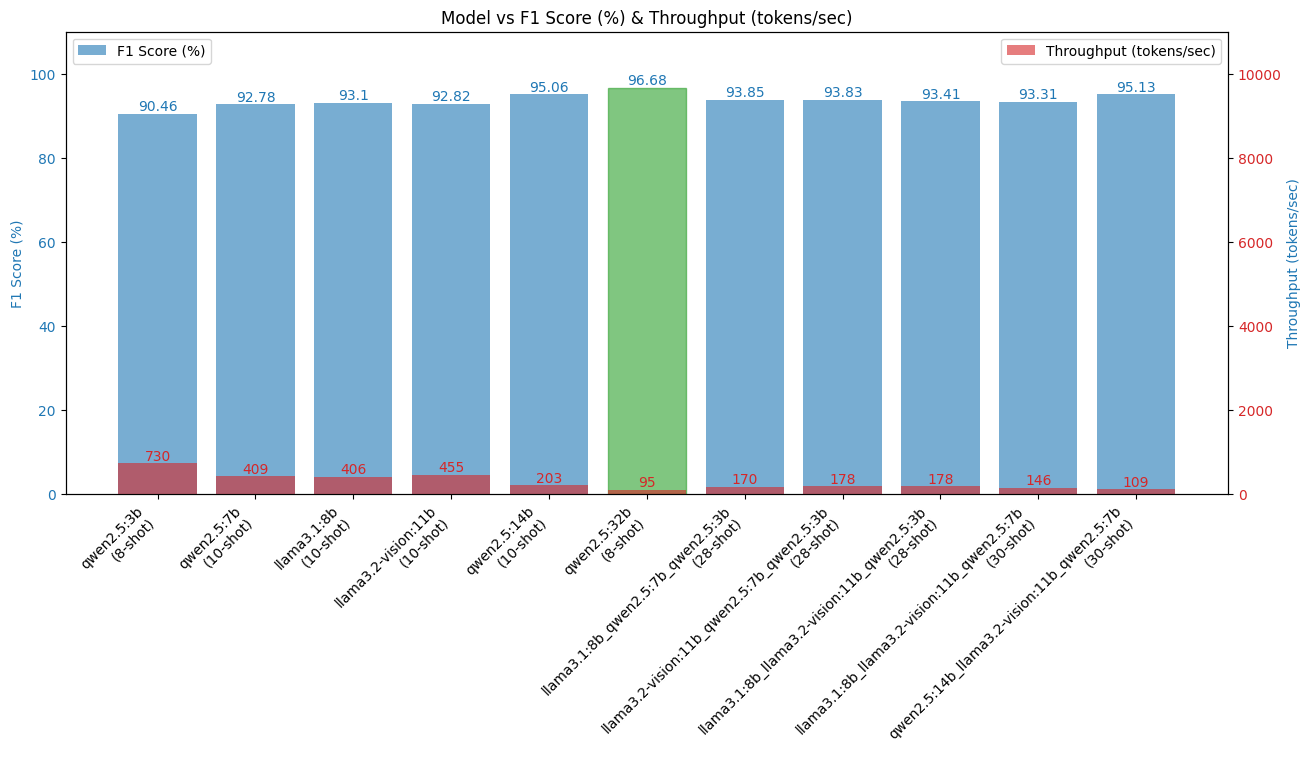

In [86]:
plot_metrics_bar_charts(best_top_metrics_df, second_ylim=[0, 11000])

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


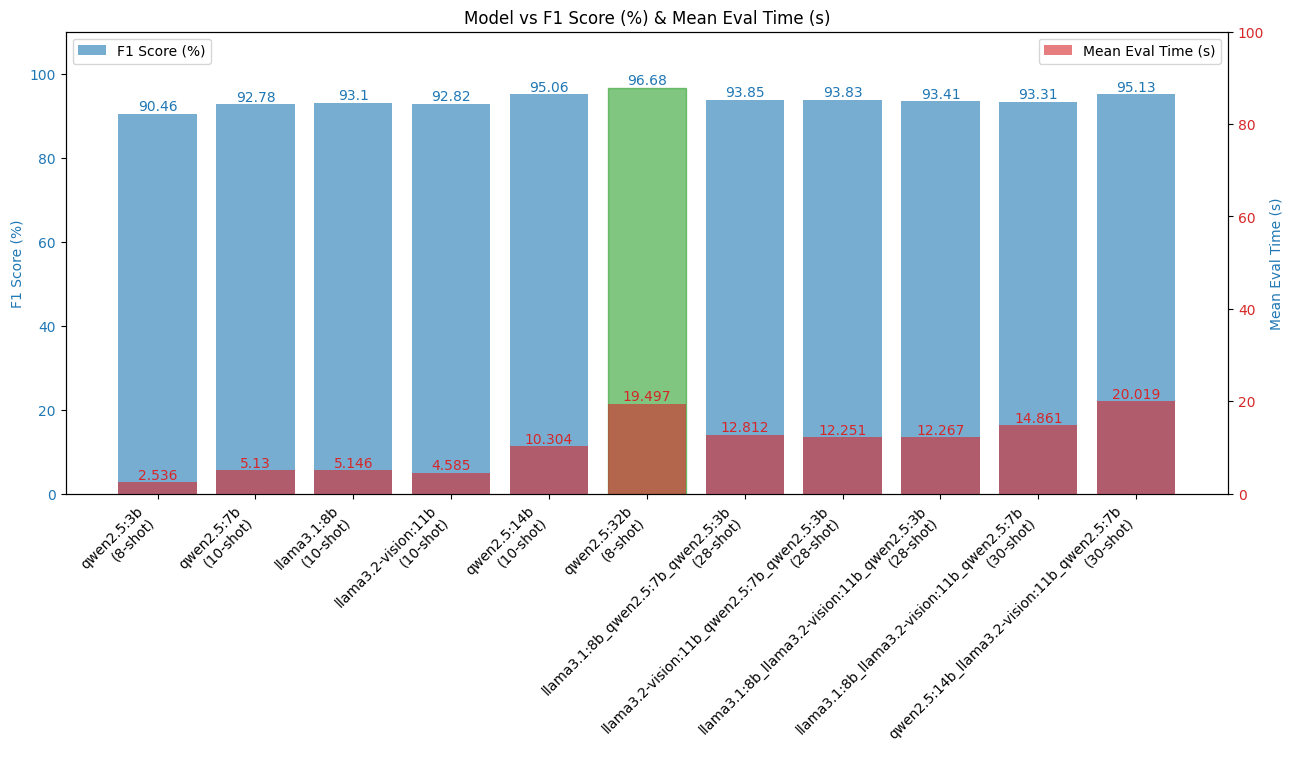

In [87]:
plot_metrics_bar_charts(
    best_top_metrics_df,
    second_column="eval_time",
    second_title="Mean Eval Time (s)",
    second_ylim=(0, 100),
    second_decimals=3,
)

In [88]:
top_metrics_df.describe()

shots  eval_time         f1   accuracy  f1_raw  accuracy_raw  \
count  15.000000  15.000000  15.000000  15.000000    15.0          15.0   
mean   14.600000   8.556533   0.864656   0.854403     0.0           0.0   
std    10.848305   6.423156   0.144499   0.151525     0.0           0.0   
min     0.000000   1.192000   0.466507   0.497820     0.0           0.0   
25%     8.000000   3.082500   0.873964   0.860942     0.0           0.0   
50%    10.000000   5.146000   0.931014   0.931125     0.0           0.0   
75%    28.000000  12.539500   0.938425   0.934176     0.0           0.0   
max    30.000000  20.019000   0.966846   0.965998     0.0           0.0   

       ratio_valid_categories  total_tokens   eval_speed  
count               15.000000  1.500000e+01    15.000000  
mean                 0.990933  2.233277e+06   435.562964  
std                  0.019556  4.078577e+05   425.495756  
min                  0.937228  1.241517e+06    95.141725  
25%                  0.996949  2.125684e+06   174.258704  
50%                  1.000000  2.408458e+06   352.115700  
75%                  1.000000  2.505002e+06   525.933480  
max                  1.000000  2.505690e+06  1761.567965

In [89]:
metrics_df.to_csv(results_path.replace(".csv", "_metrics.csv"), index=False)
top_metrics_df.to_csv(results_path.replace(".csv", "_top_metrics.csv"), index=False)

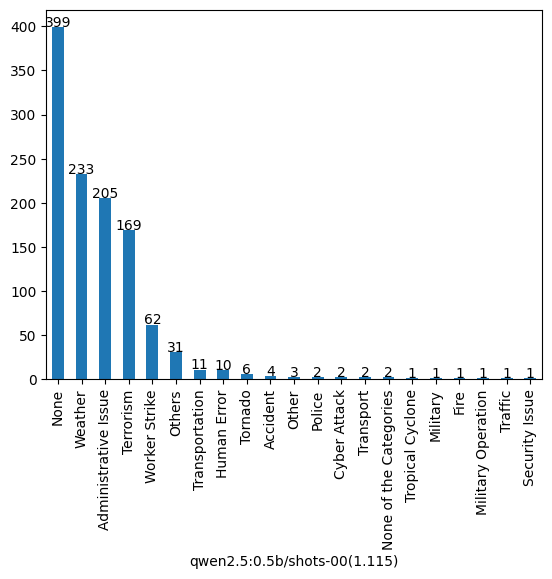

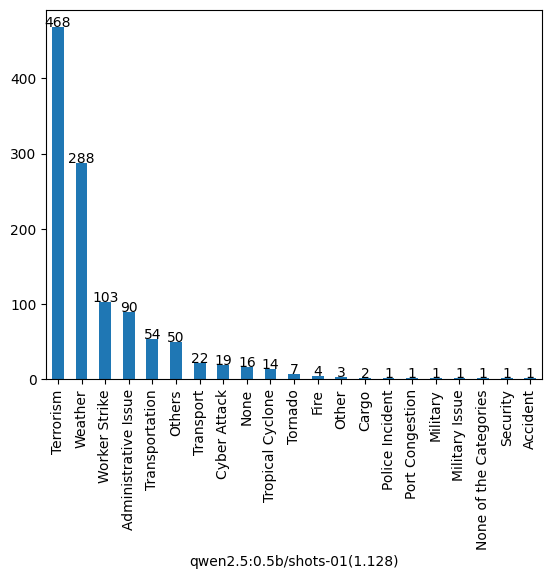

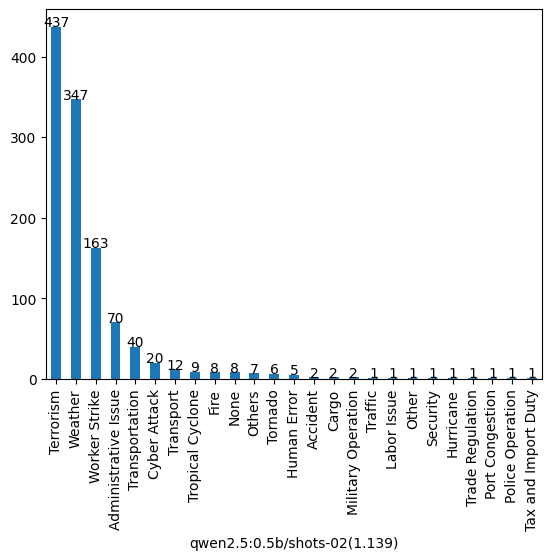

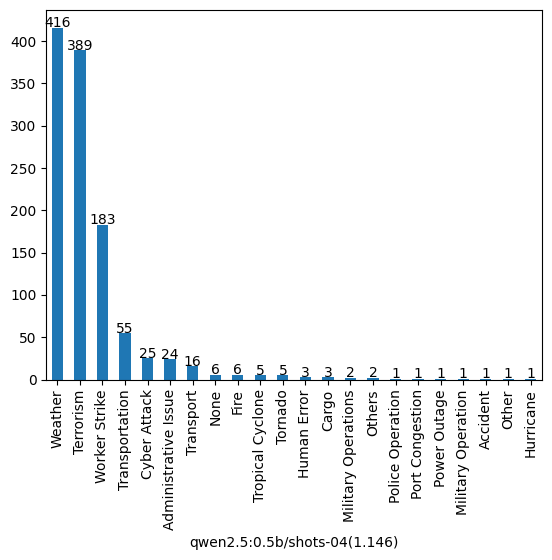

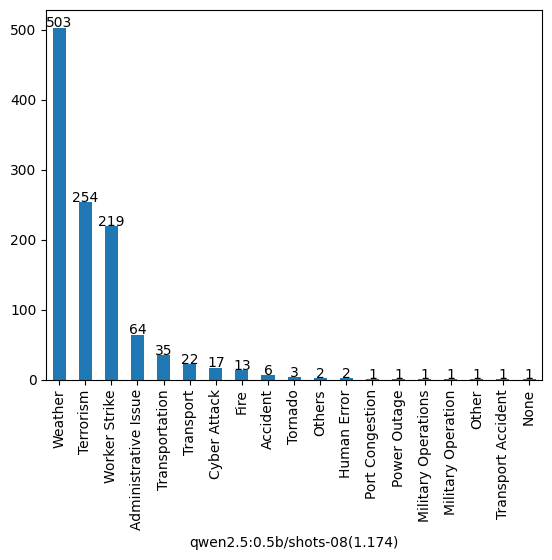

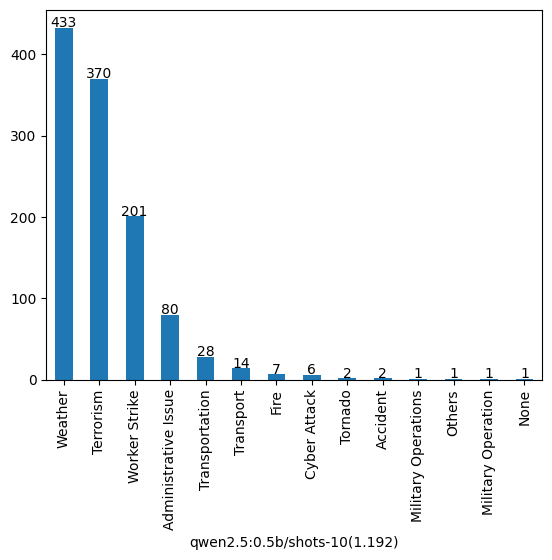

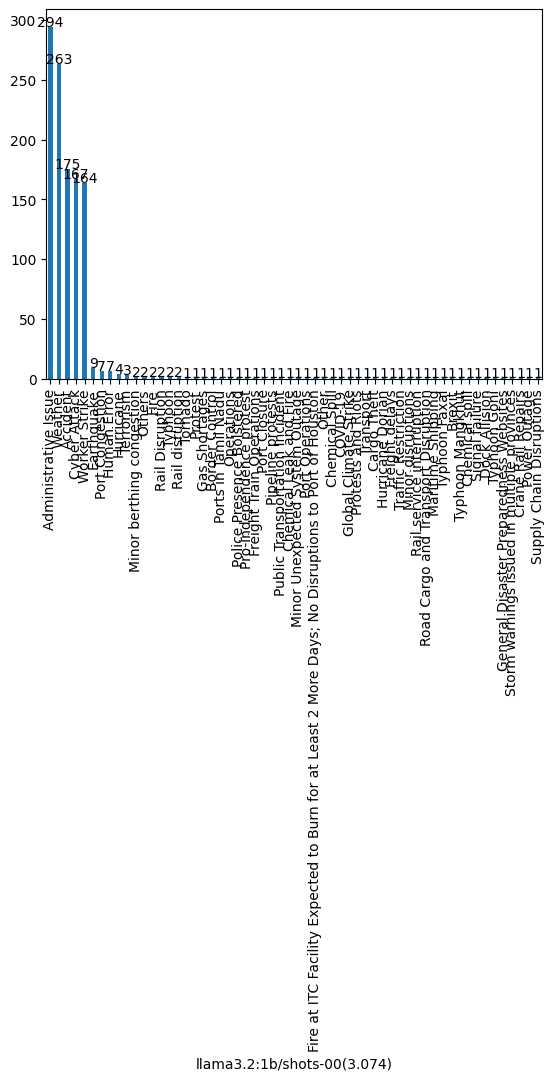

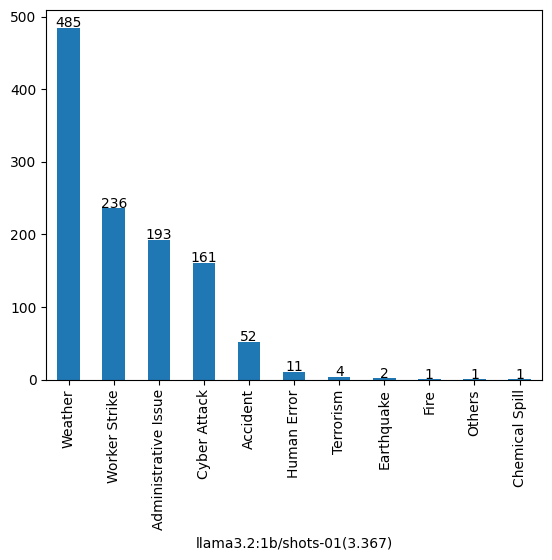

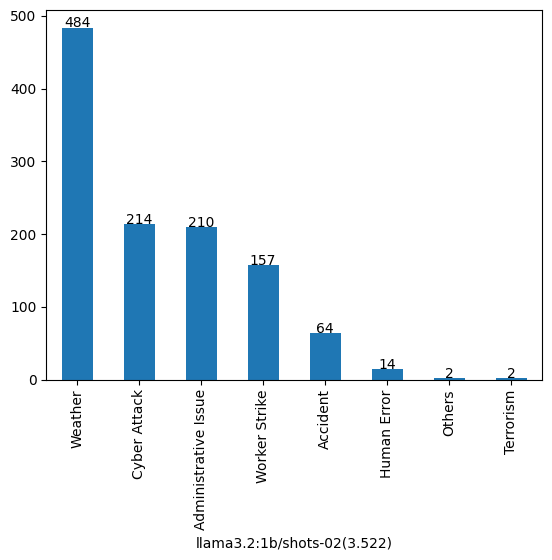

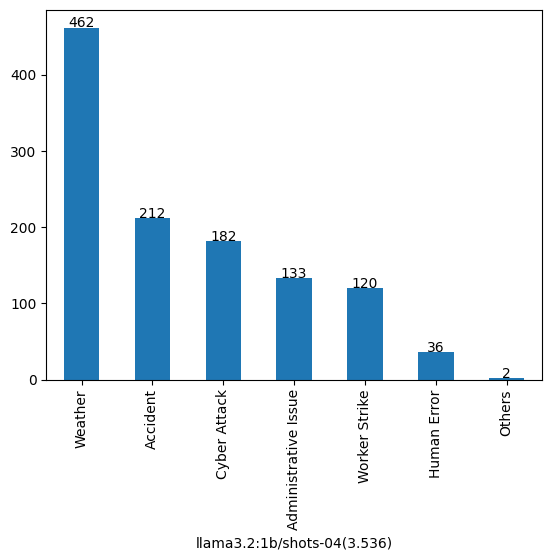

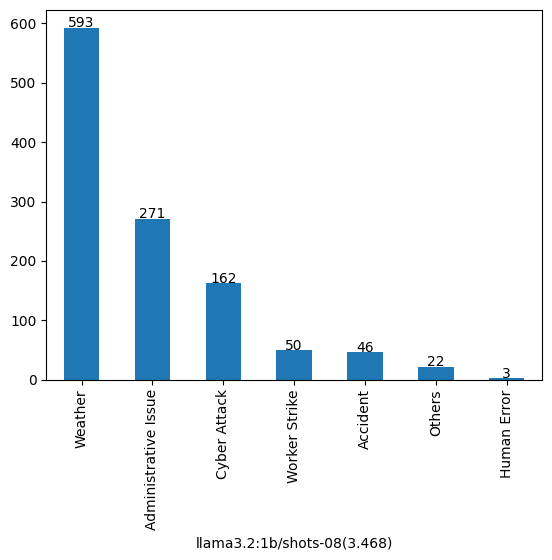

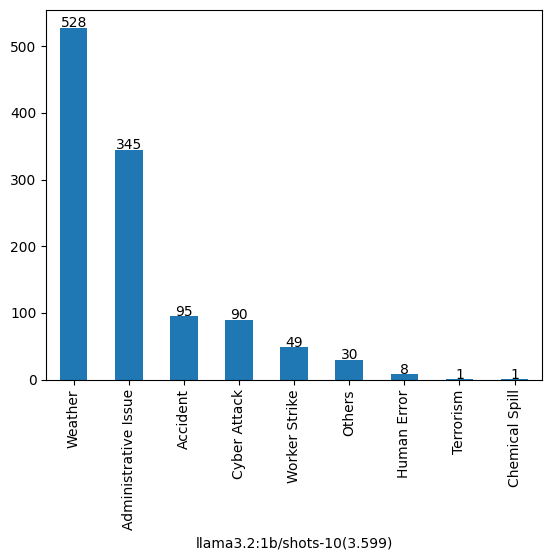

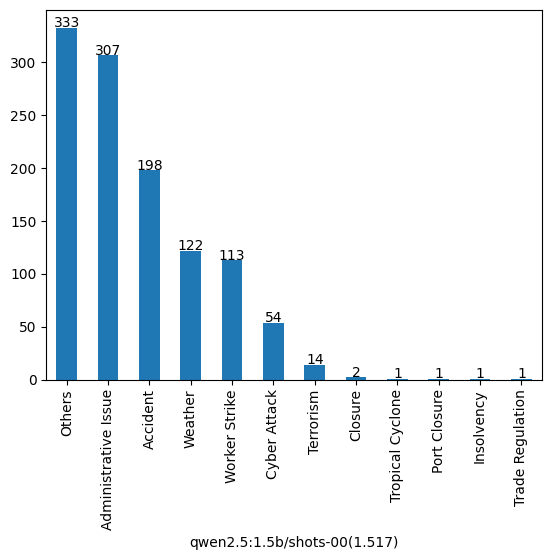

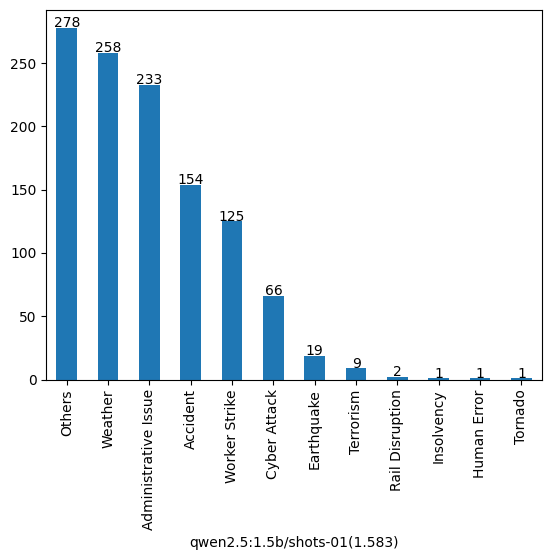

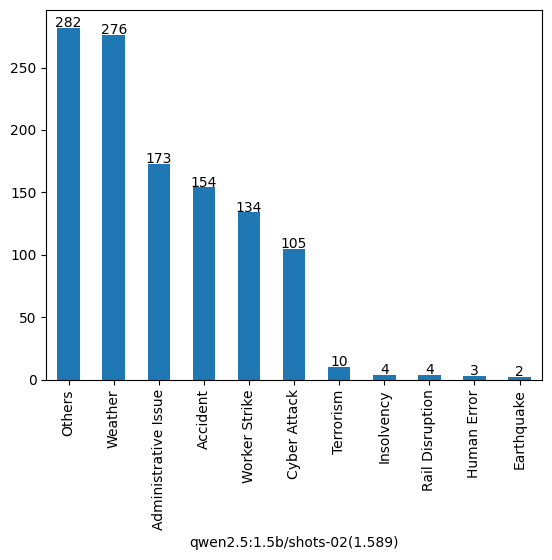

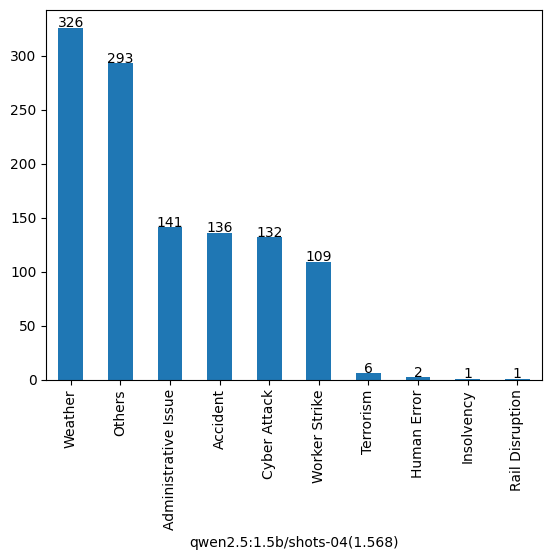

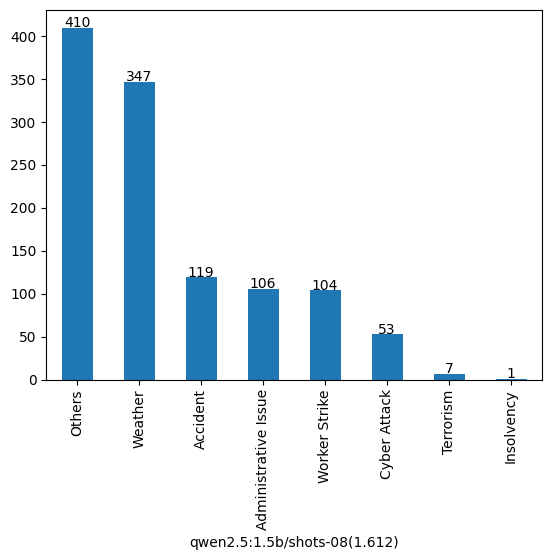

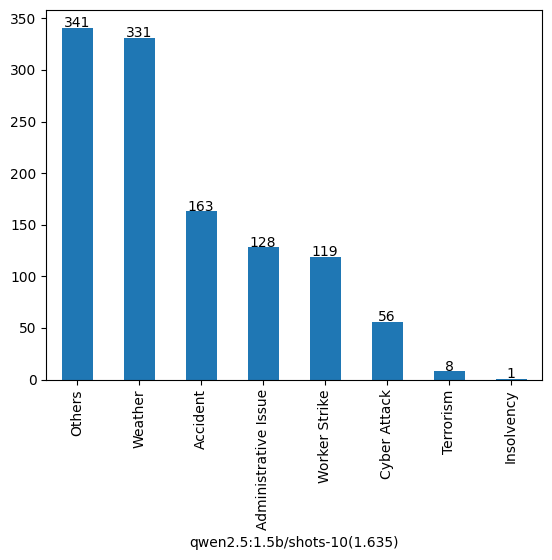

category not in json: {}


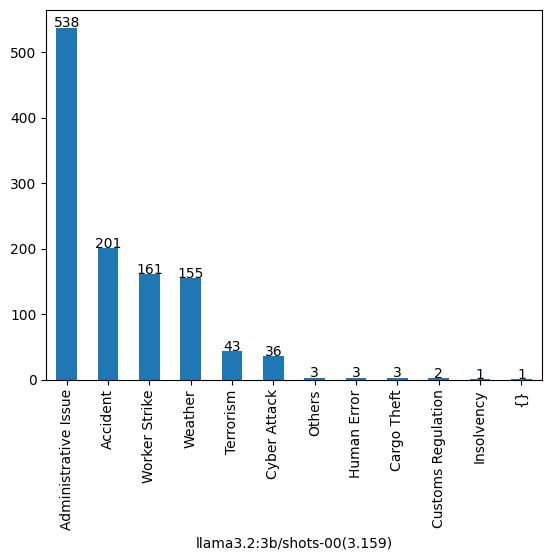

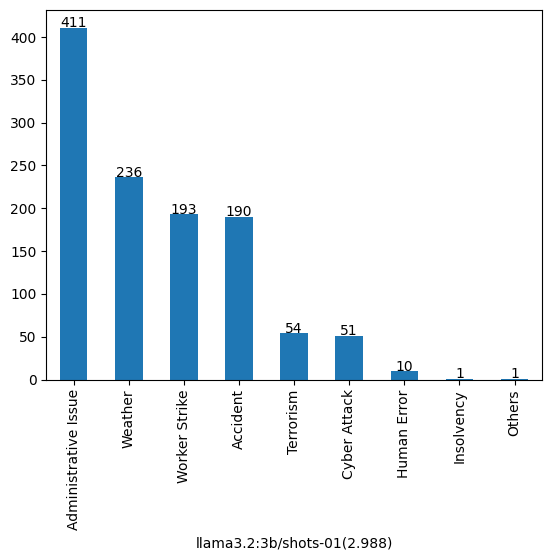

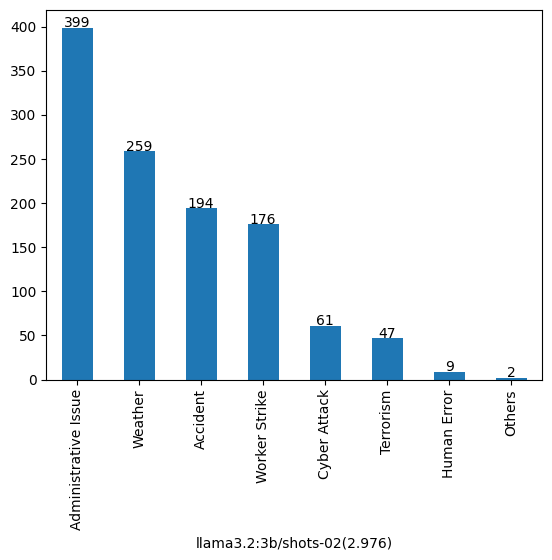

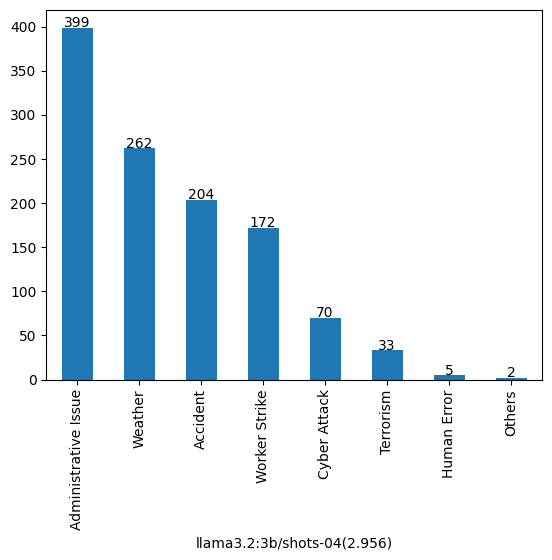

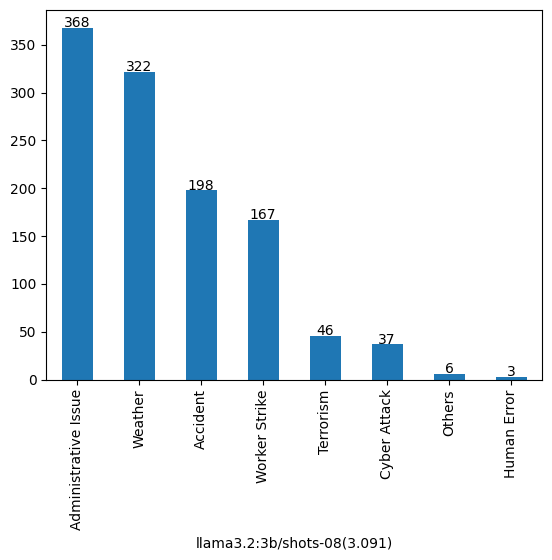

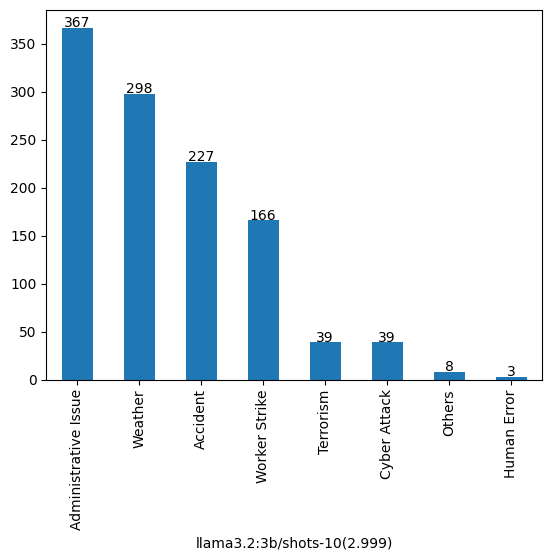

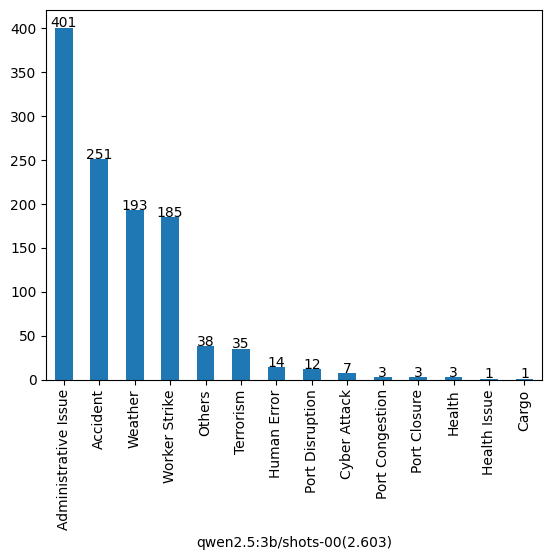

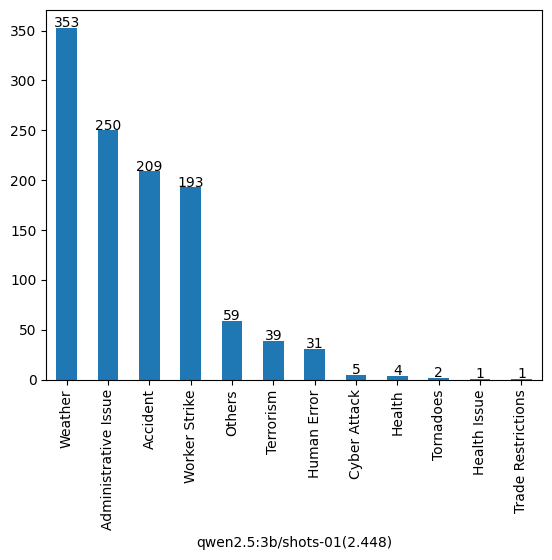

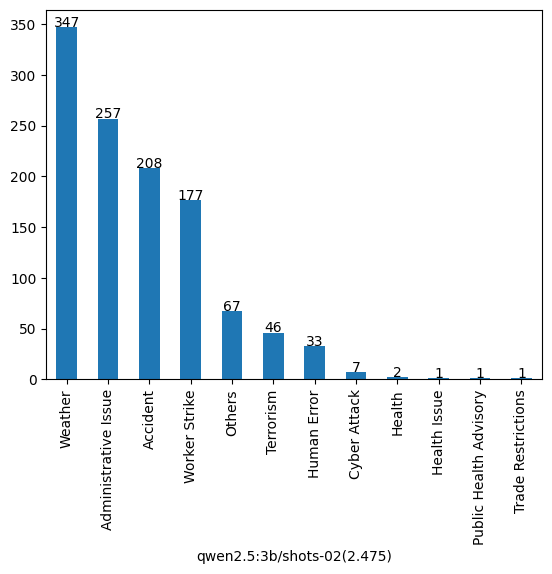

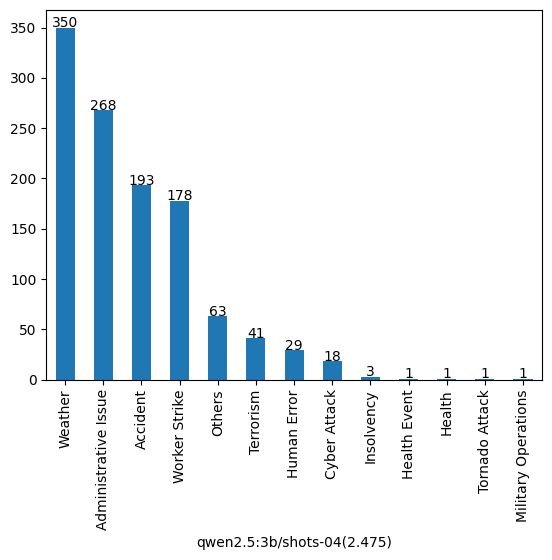

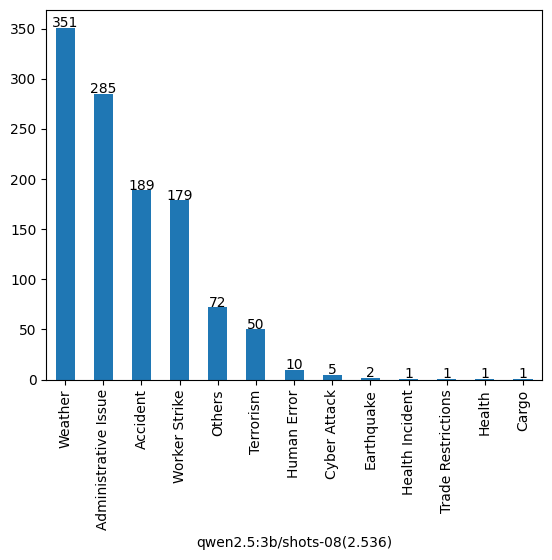

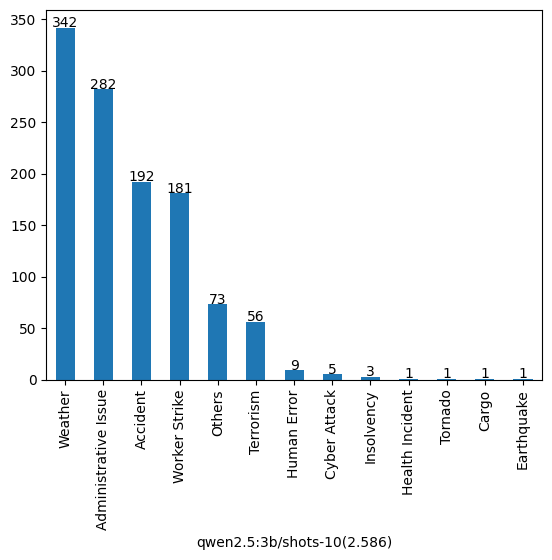

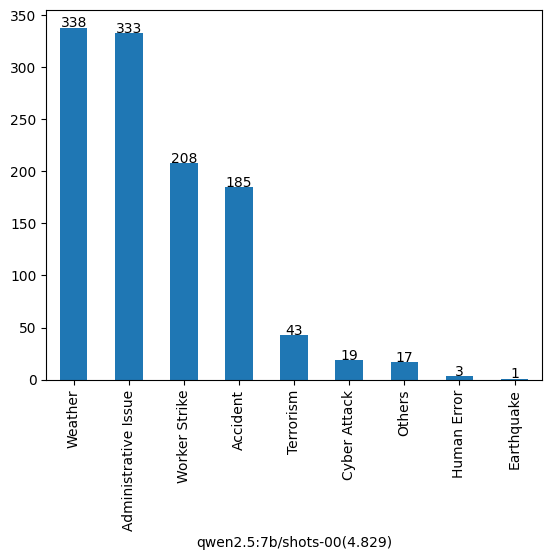

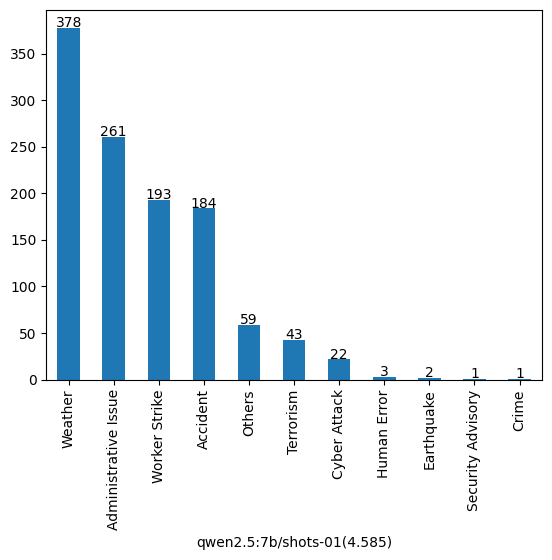

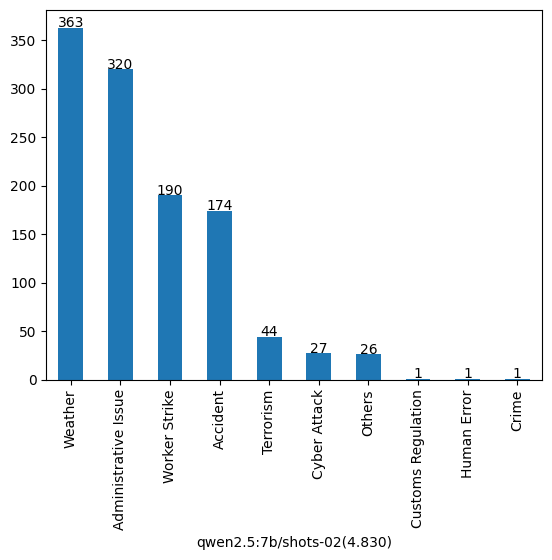

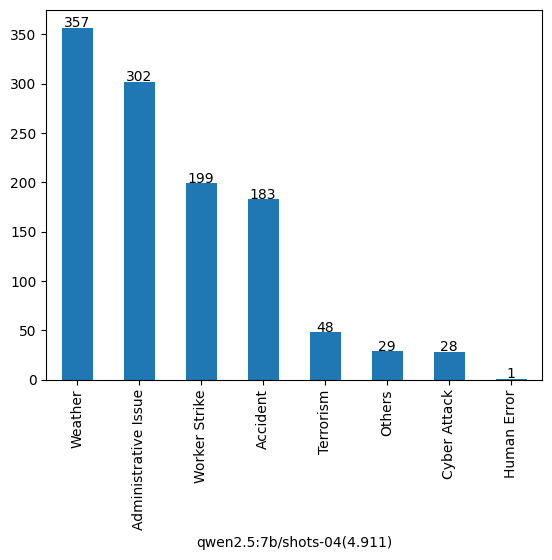

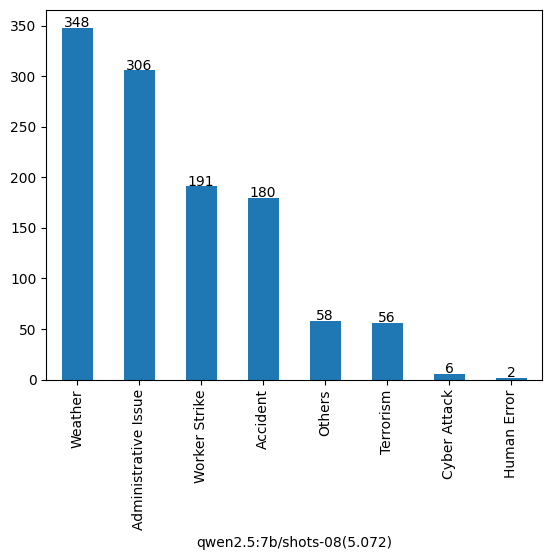

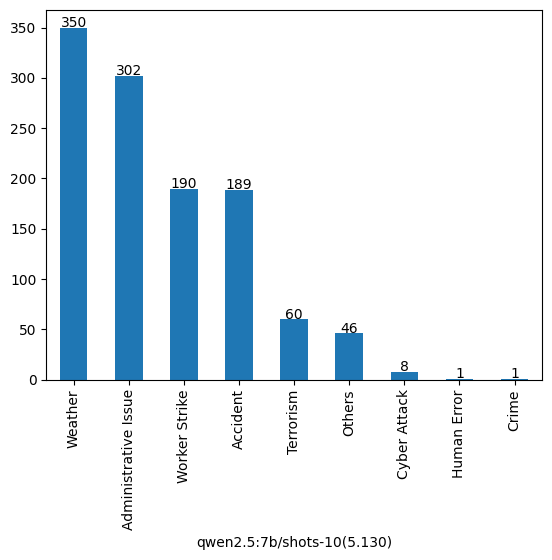

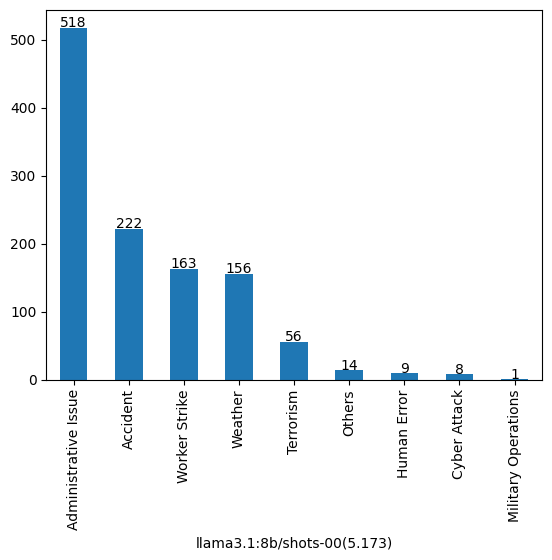

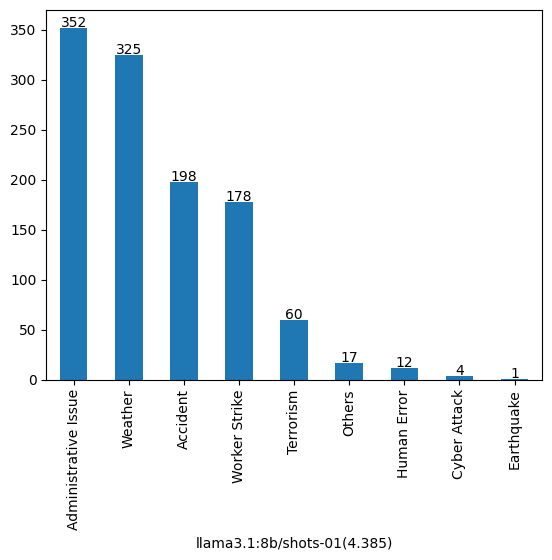

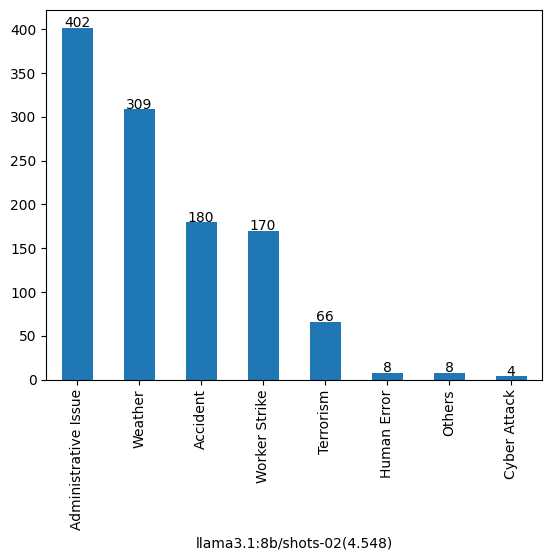

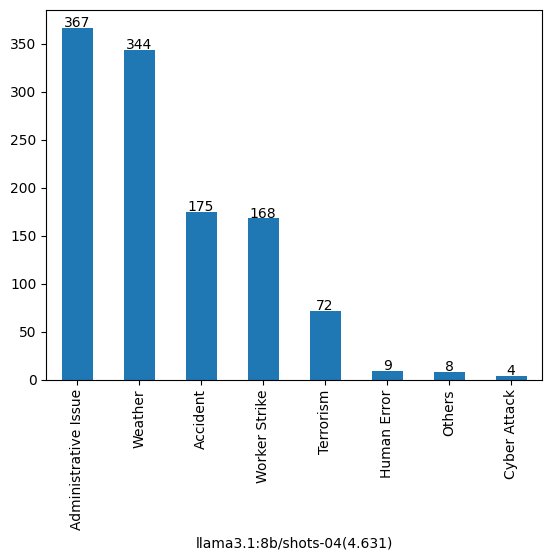

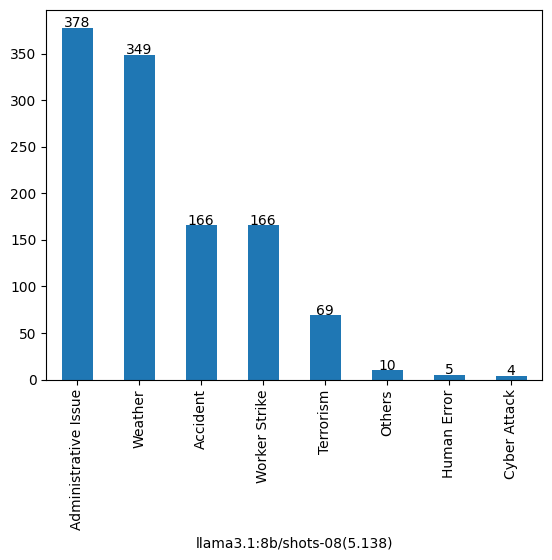

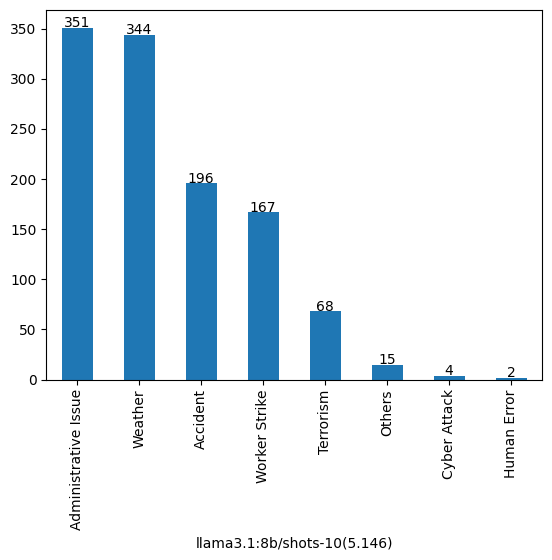

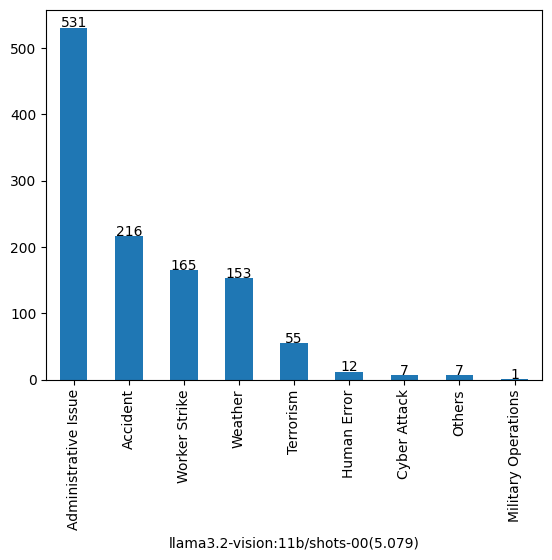

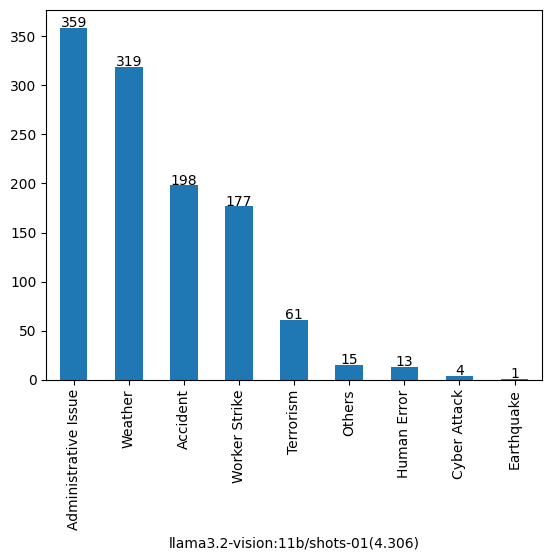

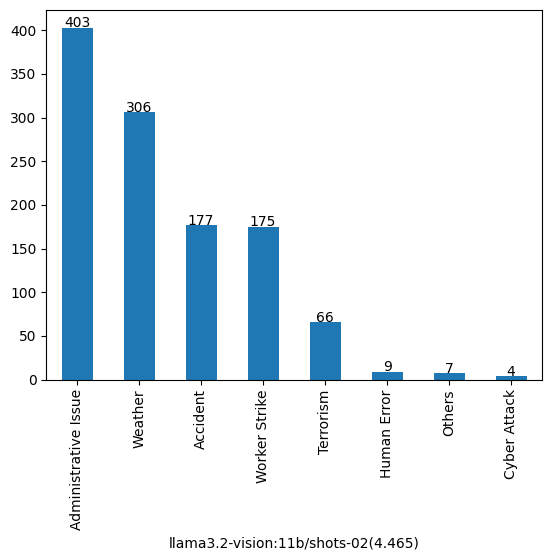

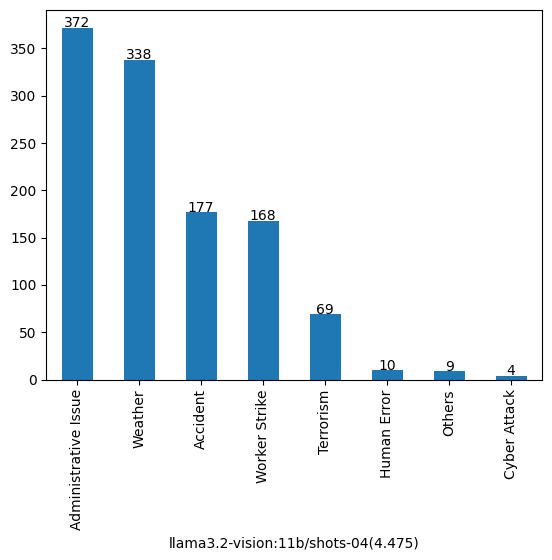

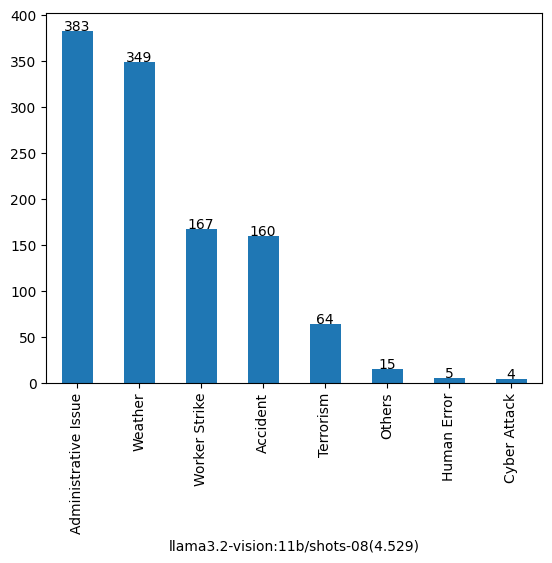

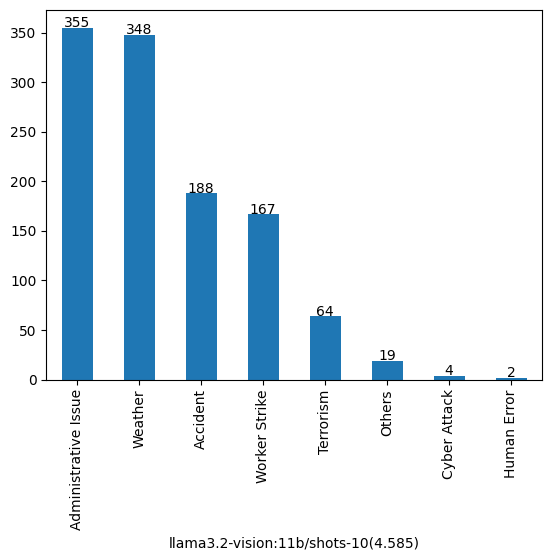

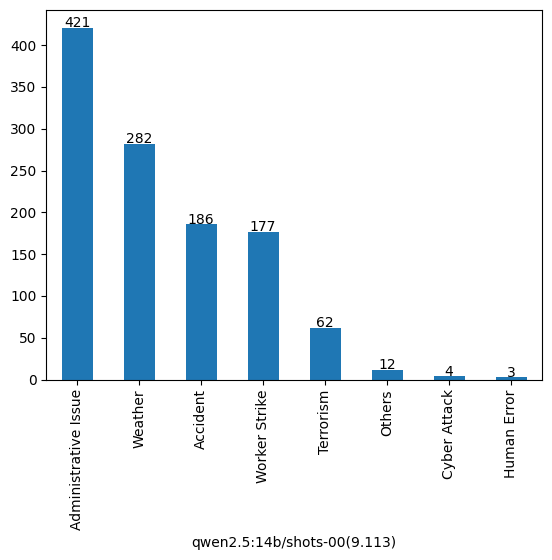

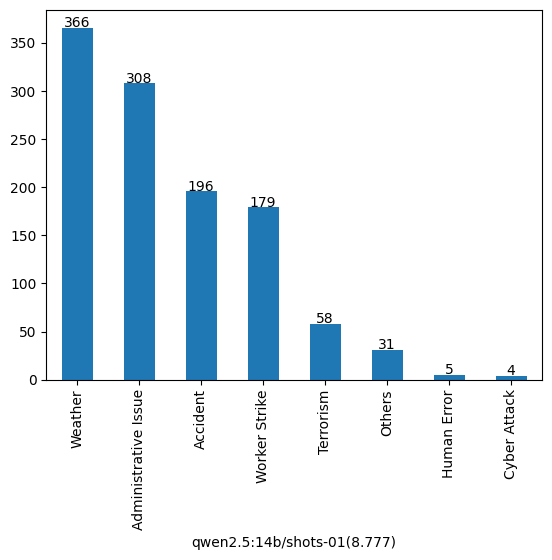

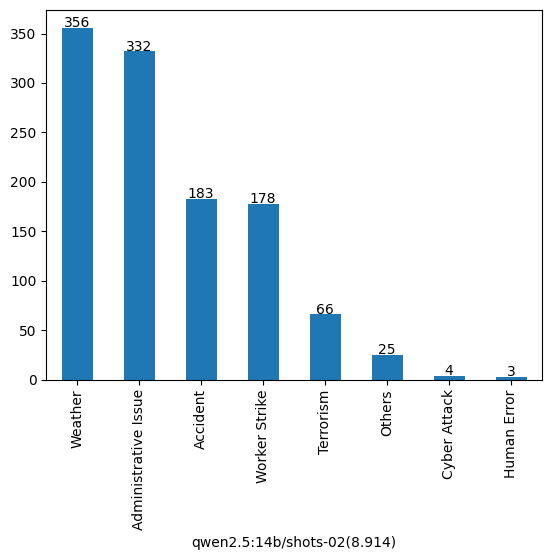

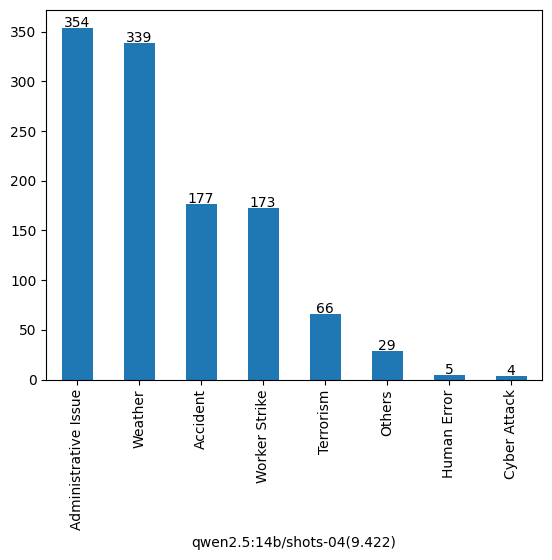

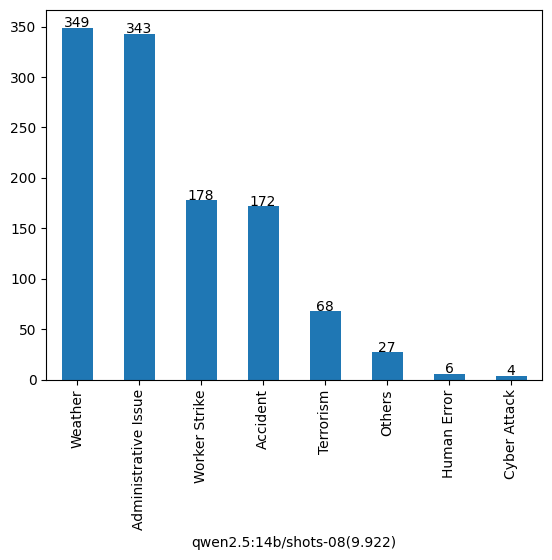

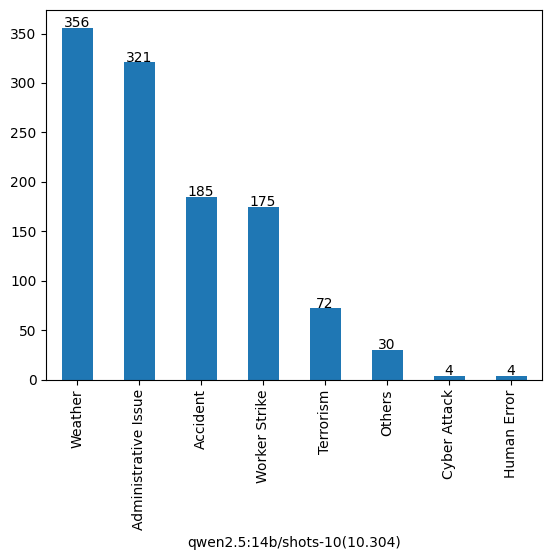

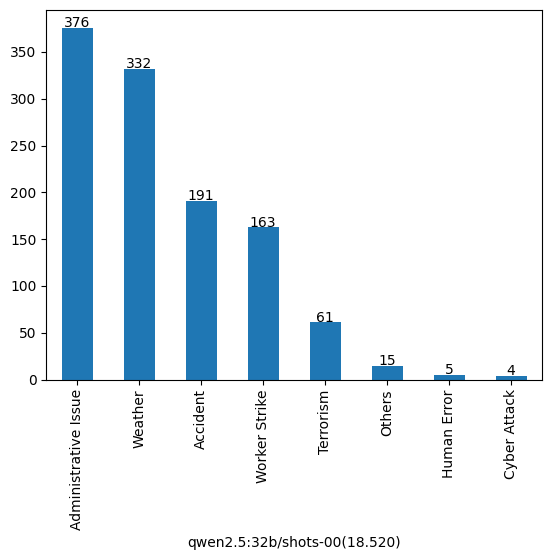

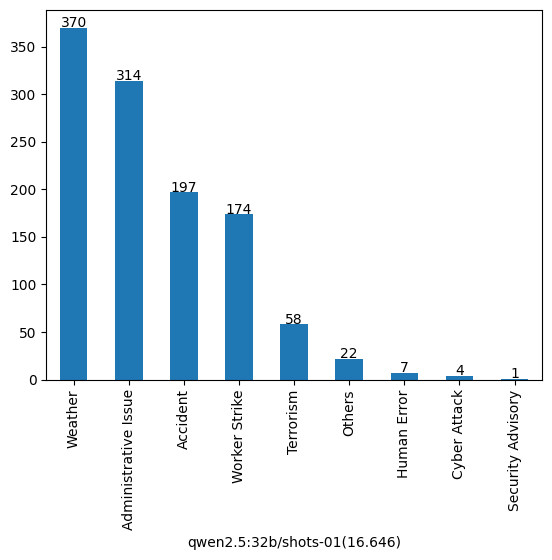

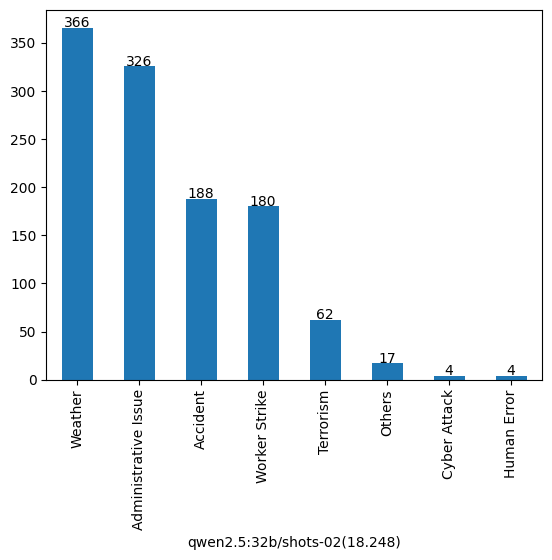

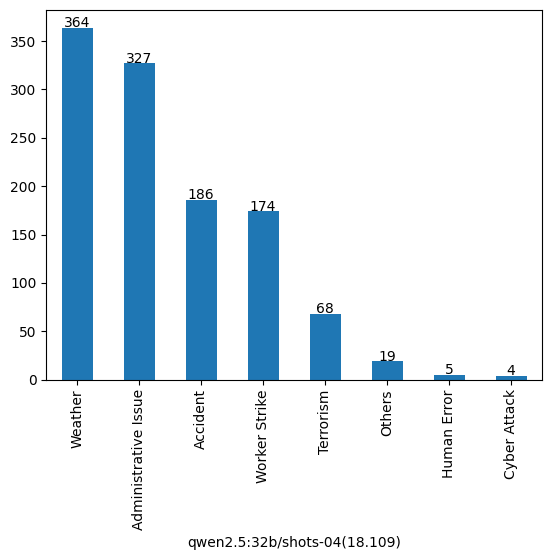

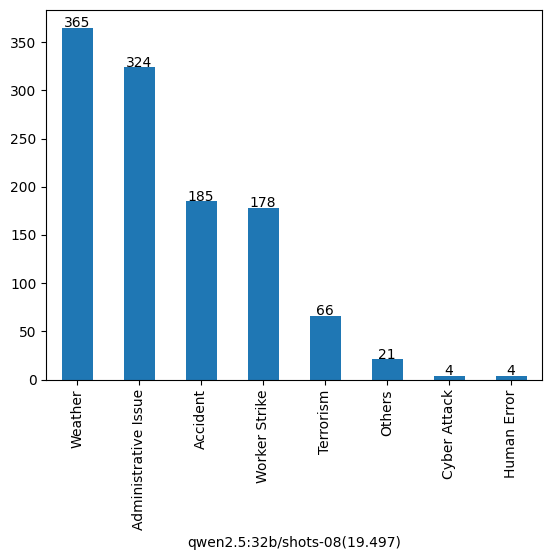

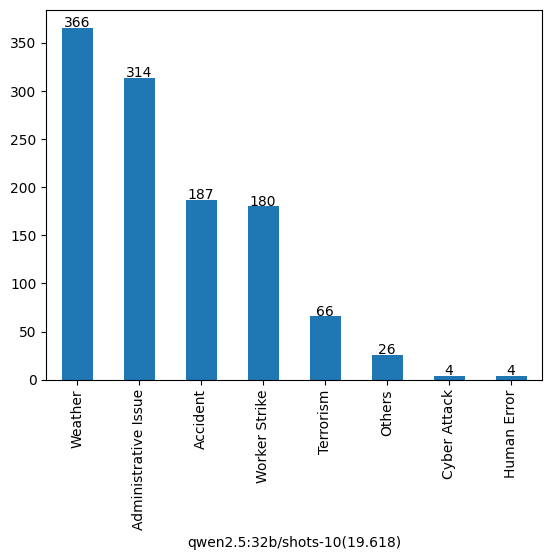

In [90]:
from llm_toolkit.data_utils import plot_bar_chart, extract_answer

for column in result_columns:
    plot_bar_chart(df, column, preprocess_func=extract_answer)